In [51]:
# Author: Alison Silldorff
# File: sql_analysis_work.py
# Date: 3/17/2025
# Purpose: Use SQL database to analyze data.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import mysql.connector
from mysql.connector import Error
import json
from datetime import datetime
import csv
import unicodedata
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.ticker as ticker

password = open("C:\\Users\\12676\\mysqlinfo", 'r').read()

Establish a MySQL connection:

In [52]:
connection = mysql.connector.connect(host='localhost', 
                                        database='shows_db',
                                        user='root',
                                        password=password, use_pure=True, buffered=True)

Get the opening and closing date from every stage work. Convert these dates to datetime objects, and add a column that contains the opening year only:

In [53]:
def take_year(date_elem):
    return date_elem.year

query1 = "SELECT opening_date, closing_date FROM stage_work"
dates_df = pd.read_sql_query(query1, con=connection)
dates_df = dates_df.applymap(pd.to_datetime)
dates_df['opening_year'] = dates_df['opening_date'].apply(take_year)


C:\Users\12676\AppData\Local\Temp\ipykernel_22040\3269346546.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dates_df = pd.read_sql_query(query1, con=connection)
C:\Users\12676\AppData\Local\Temp\ipykernel_22040\3269346546.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dates_df = dates_df.applymap(pd.to_datetime)


Plot a line graph of how many shows opened each year:

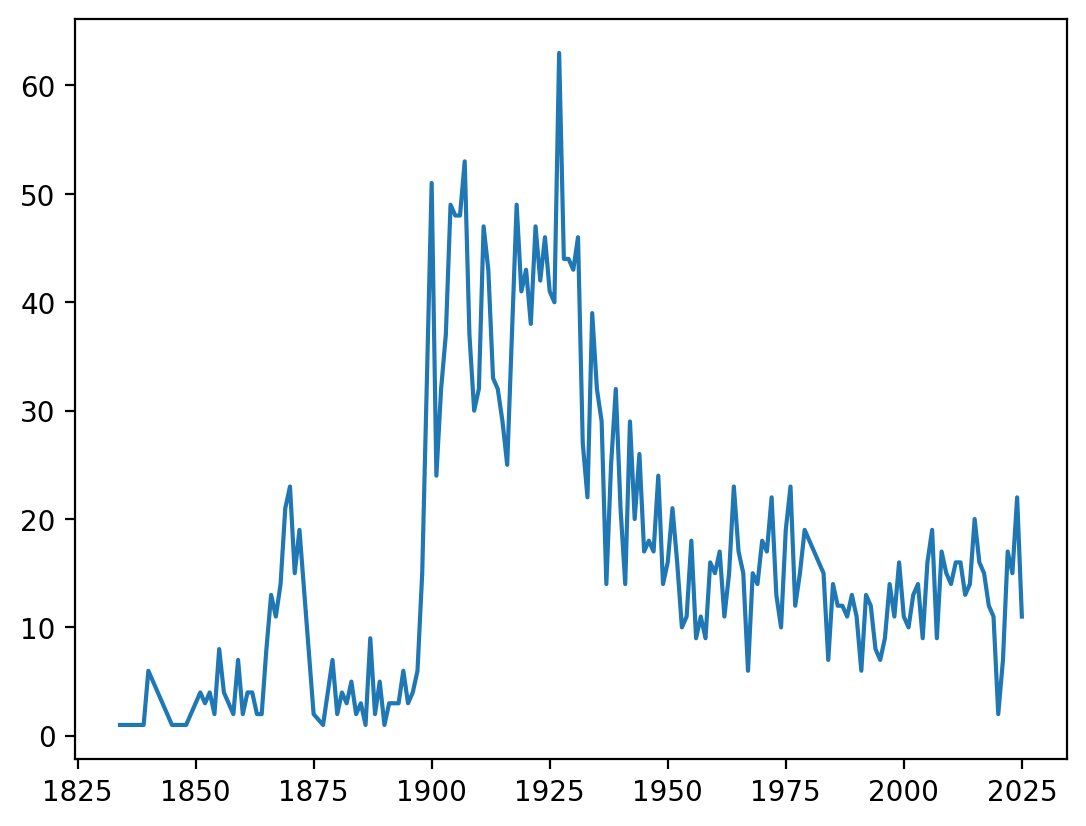

In [54]:
#dates_df['opening_date'].hist(bins=21)
overall_value_counts = dates_df['opening_year'].value_counts().sort_index()
plt.plot(overall_value_counts)
# first date is 1834, last is 2025. 210 years.

Use an INNER JOIN to get all shows tags, alongside their opening year. Put this into tags_df. Convert opening dates into datatime objects, and extract only the year. 

In [55]:
tags_df = pd.read_sql_query("SELECT ibdb_tag.tag_name, ibdb_tag.property_id, ibdb_tag.title, ibdb_tag.work_id, stage_work.opening_date, stage_work.closing_date FROM ibdb_tag INNER JOIN stage_work ON ibdb_tag.work_id=stage_work.work_id", con=connection)
tags_df['opening_date'] = tags_df['opening_date'].apply(pd.to_datetime)
tags_df['opening_year'] = tags_df['opening_date'].apply(take_year)
counts  = tags_df['tag_name'].value_counts()
tags_df


C:\Users\12676\AppData\Local\Temp\ipykernel_22040\347697913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tags_df = pd.read_sql_query("SELECT ibdb_tag.tag_name, ibdb_tag.property_id, ibdb_tag.title, ibdb_tag.work_id, stage_work.opening_date, stage_work.closing_date FROM ibdb_tag INNER JOIN stage_work ON ibdb_tag.work_id=stage_work.work_id", con=connection)


,tag_name,property_id,title,work_id,opening_date,closing_date,opening_year
0,Musical,0000,'Round New York in 80 Minutes,00000011,1899-11-06,1900-02-24,1899.0
1,Original,0000,'Round New York in 80 Minutes,00000011,1899-11-06,1900-02-24,1899.0
2,Broadway,0000,'Round New York in 80 Minutes,00000011,1899-11-06,1900-02-24,1899.0
3,Comedy,0000,'Round New York in 80 Minutes,00000011,1899-11-06,1900-02-24,1899.0
4,Musical,0001,"""It's a Bird...It's a Plane...It's Superman""",00010011,1966-03-29,1966-07-17,1966.0
...,...,...,...,...,...,...,...
12288,Revue,2584,The Passing Show of 1922,25840011,1922-09-20,1922-12-02,1922.0
12289,Musical,2585,The Regatta Girl,25850011,1900-03-14,1900-03-31,1900.0
12290,Original,2585,The Regatta Girl,25850011,1900-03-14,1900-03-31,1900.0
12291,Broadway,2585,The Regatta Girl,25850011,1900-03-14,1900-03-31,1900.0


Create a bar graph of shows in the genres Minstrel, Revue, Extravaganza, Comedy, and Burlesque:

<Axes: xlabel='tag_name'>

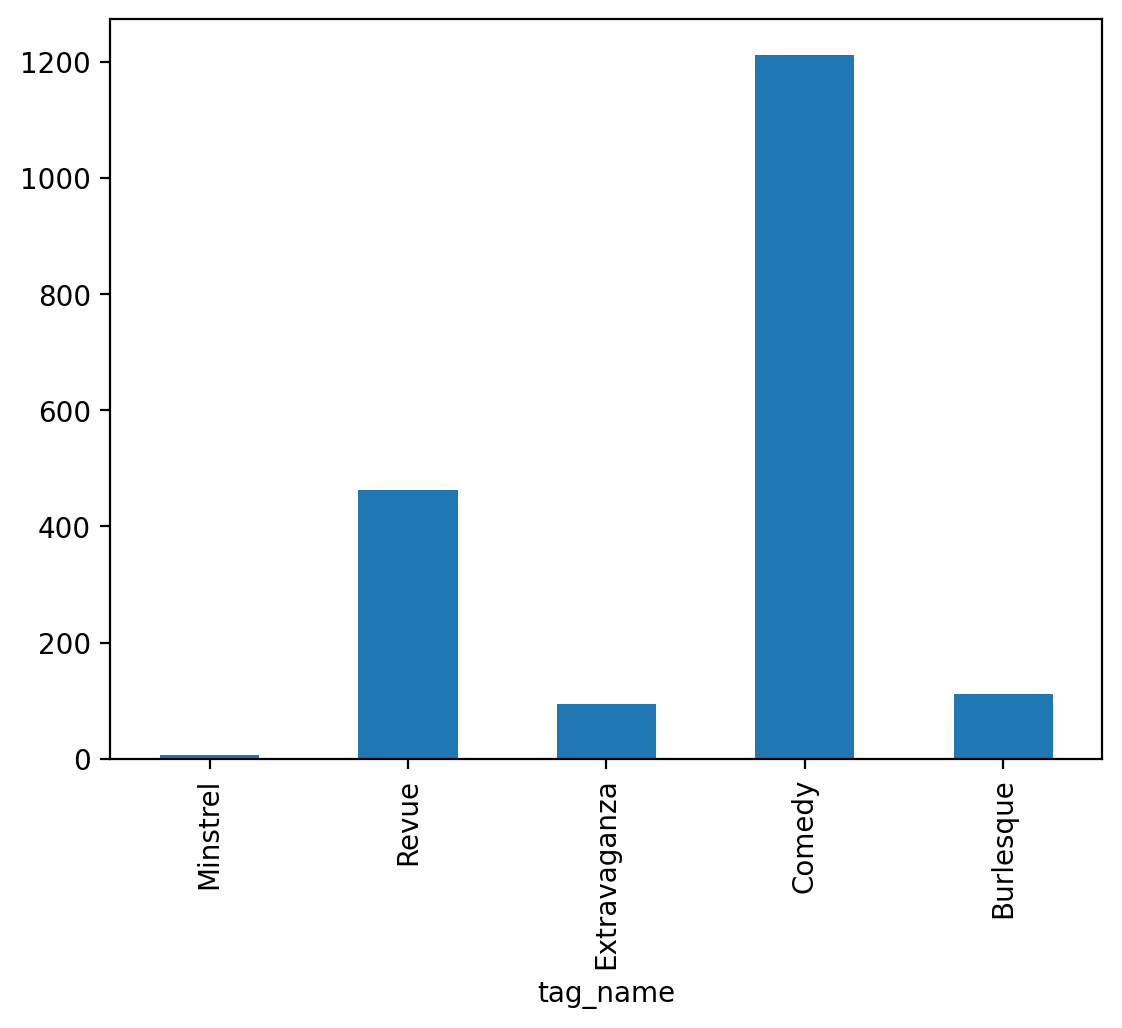

In [56]:
bars1 = ['Original', 'Revival']
vals1 = [counts['Original'], counts['Revival']]
bars2 = ['Minstrel', 'Revue', 'Extravaganza', 'Comedy', 'Burlesque']
counts[bars2].plot.bar(x=bars2)

Make sub-dataframes that include only shows of a certain genre:

In [57]:
musical_df = tags_df[tags_df['tag_name']=='Musical'] # control dataset! This should be all of the shows.
burlesque_df = tags_df[tags_df['tag_name']=='Burlesque']
minstrel_df = tags_df[tags_df['tag_name']=='Minstrel']
revue_df = tags_df[tags_df['tag_name']=='Revue']
extravaganza_df = tags_df[tags_df['tag_name']=='Extravaganza']
opera_df = tags_df[tags_df['tag_name']=='Opera']
operetta_df = tags_df[tags_df['tag_name']=='Operetta']
vaudeville_df = tags_df[tags_df['tag_name']=='Vaudeville']
variety_df = tags_df[tags_df['tag_name']=='Variety']
comedy_df = tags_df[tags_df['tag_name']=='Comedy']

Plot the value counts by genre over time, normalized against the total shows that opened each year:

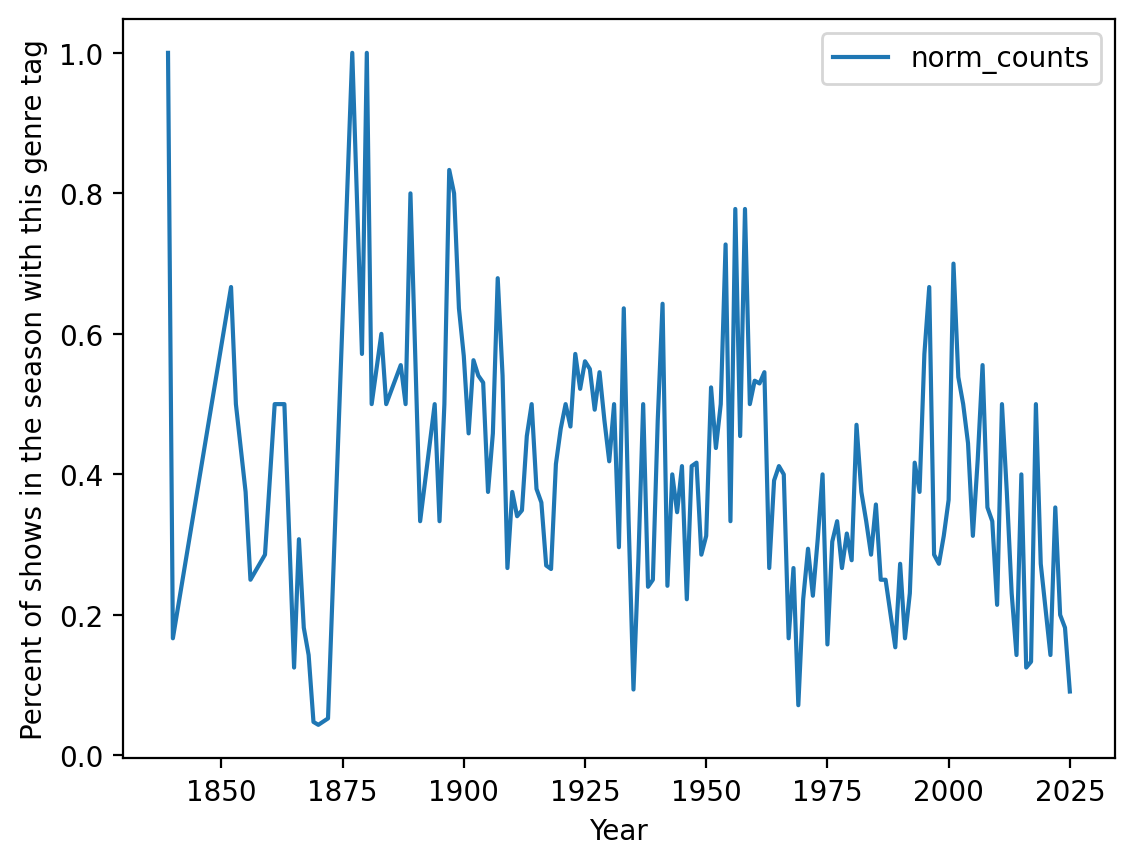

In [58]:
# for the value counts of a specific tag, divide by the total number of shows that opened that year.
def norm_against_totals(row):
    year = row['opening_year']
    count = row['count']
    year_total = overall_value_counts[year]
    return (count / year_total)

# Alter which df you use in this line to look at different genre tags:
genre_counts = pd.DataFrame(comedy_df['opening_year'].value_counts().sort_index())
genre_counts = genre_counts.reset_index()
genre_counts['norm_counts'] = genre_counts.apply(norm_against_totals, axis=1)
genre_counts.plot(x='opening_year', y='norm_counts')
plt.xlabel("Year")
plt.ylabel("Percent of shows in the season with this genre tag")
plt.show()

In [59]:
burlesque_df1 = pd.DataFrame(burlesque_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
minstrel_df1 = pd.DataFrame(minstrel_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
revue_df1 = pd.DataFrame(revue_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
extravaganza_df1 = pd.DataFrame(extravaganza_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
vaudeville_df1 = pd.DataFrame(vaudeville_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
variety_df1 = pd.DataFrame(variety_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)


operetta_df1 = pd.DataFrame(operetta_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
opera_df1 = pd.DataFrame(opera_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
musical_df1 = pd.DataFrame(musical_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
comedy_df1 = pd.DataFrame(comedy_df['opening_year'].value_counts().sort_index()).reindex(range(1834,2026), fill_value=0)
musical_df1
print(musical_df1.loc[1899])
print(comedy_df1.loc[1899])

count    33
Name: 1899, dtype: int64
count    21
Name: 1899, dtype: int64


Now let's create a stacked area graph of these different genres over time. Be careful with this library layering some things on its own and manipulating the data.

[ 0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  2  2  0  3  1  0
  0  2  0  2  0  1  0  1  4  2  2  1  1  0  1  0  0  0  0  1  0  4  2  2
  0  3  1  0  0  5  1  4  0  1  0  0  3  1  2  5 12 21 29 11 18 20 26 18
 22 36 20  8 12 16 15 15 16 11  9 10 13 17 20 19 22 24 24 23 22 31 24 21
 18 23  8 14 13  3  8  7  6  8 10  9  7  8  9  7  4  7 10  4  5 11  7  5
  8  6  7  5  7  8  8  9  6  4  9  7  6  1  4  1  4  5  5  4  4  3  7  4
  4  6  5  8  6  5  2  5  3  3  0  2  3  1  3  5  3  4  6  4  3  5  4  7
  7  7  4  5  8  5  6  5  3  8  6  3  2  8  2  2  6  3  0  1  6  3  4  1]
[ 1  0  1  0  0  1  6  0  0  0  0  1  0  0  1  0  0  4  3  4  2  8  4  3
  2  7  2  4  4  2  2  8 13 11 14 21 23 15 19  0  0  2  0  1  0  7  2  4
  3  5  2  3  1  9  2  5  1  3  0  3  6  3  4  6 15 33 51 24 32 37 49 48
 48 53 37 30 32 47 43 33 32 29 25 37 49 41 43 38 47 42 46 41 40 63 44 44
 43 46 27 22 39 32 29 14 25 32 21 14 29 20 26 17 18 17 24 14 16 21 16 10
 11 18  9 11  9 16 15 17 11 15 23 17 15  6 15 14 1

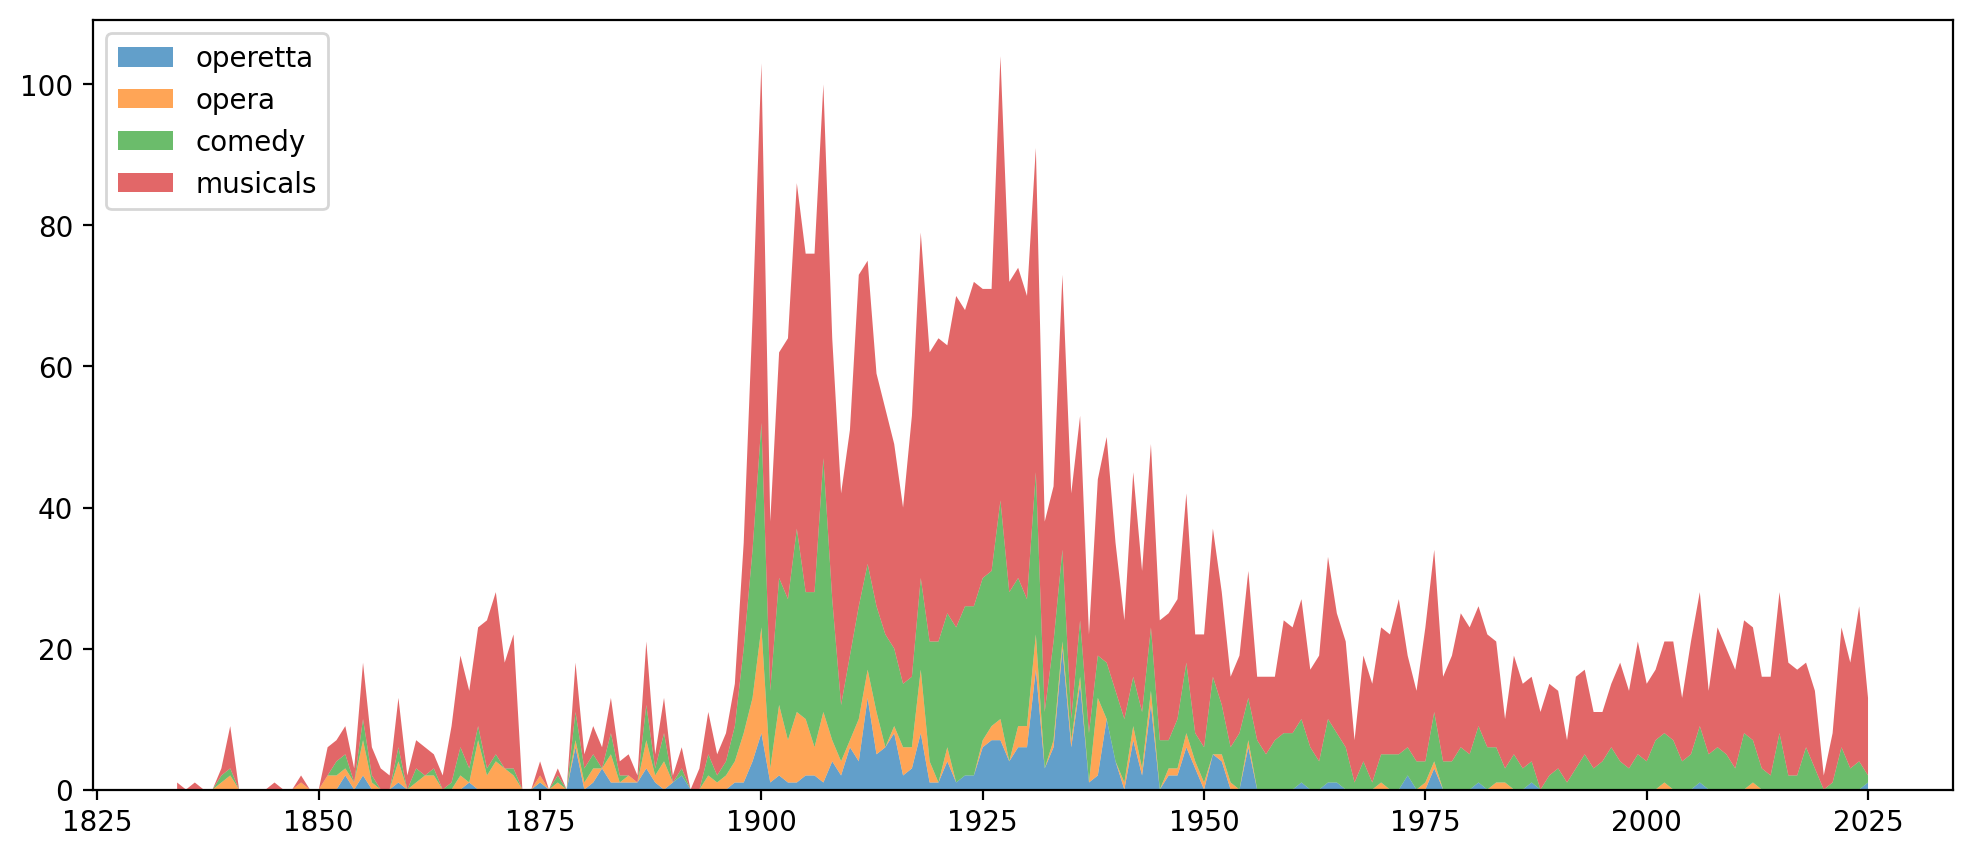

In [60]:
genre_stack = np.vstack([operetta_df1['count'], opera_df1['count'], comedy_df1['count'], musical_df1['count']])
print(genre_stack[2])
print(genre_stack[3])
fig, ax = plt.subplots(figsize=(12, 5))
layers = ax.stackplot(range(1834, 2026), genre_stack, labels=['operetta', 'opera', 'comedy', 'musicals'], alpha=0.7)
ax.legend(handles=layers, labels=['operetta', 'opera', 'comedy', 'musicals'], loc='upper left')
plt.show()

As a line graph:

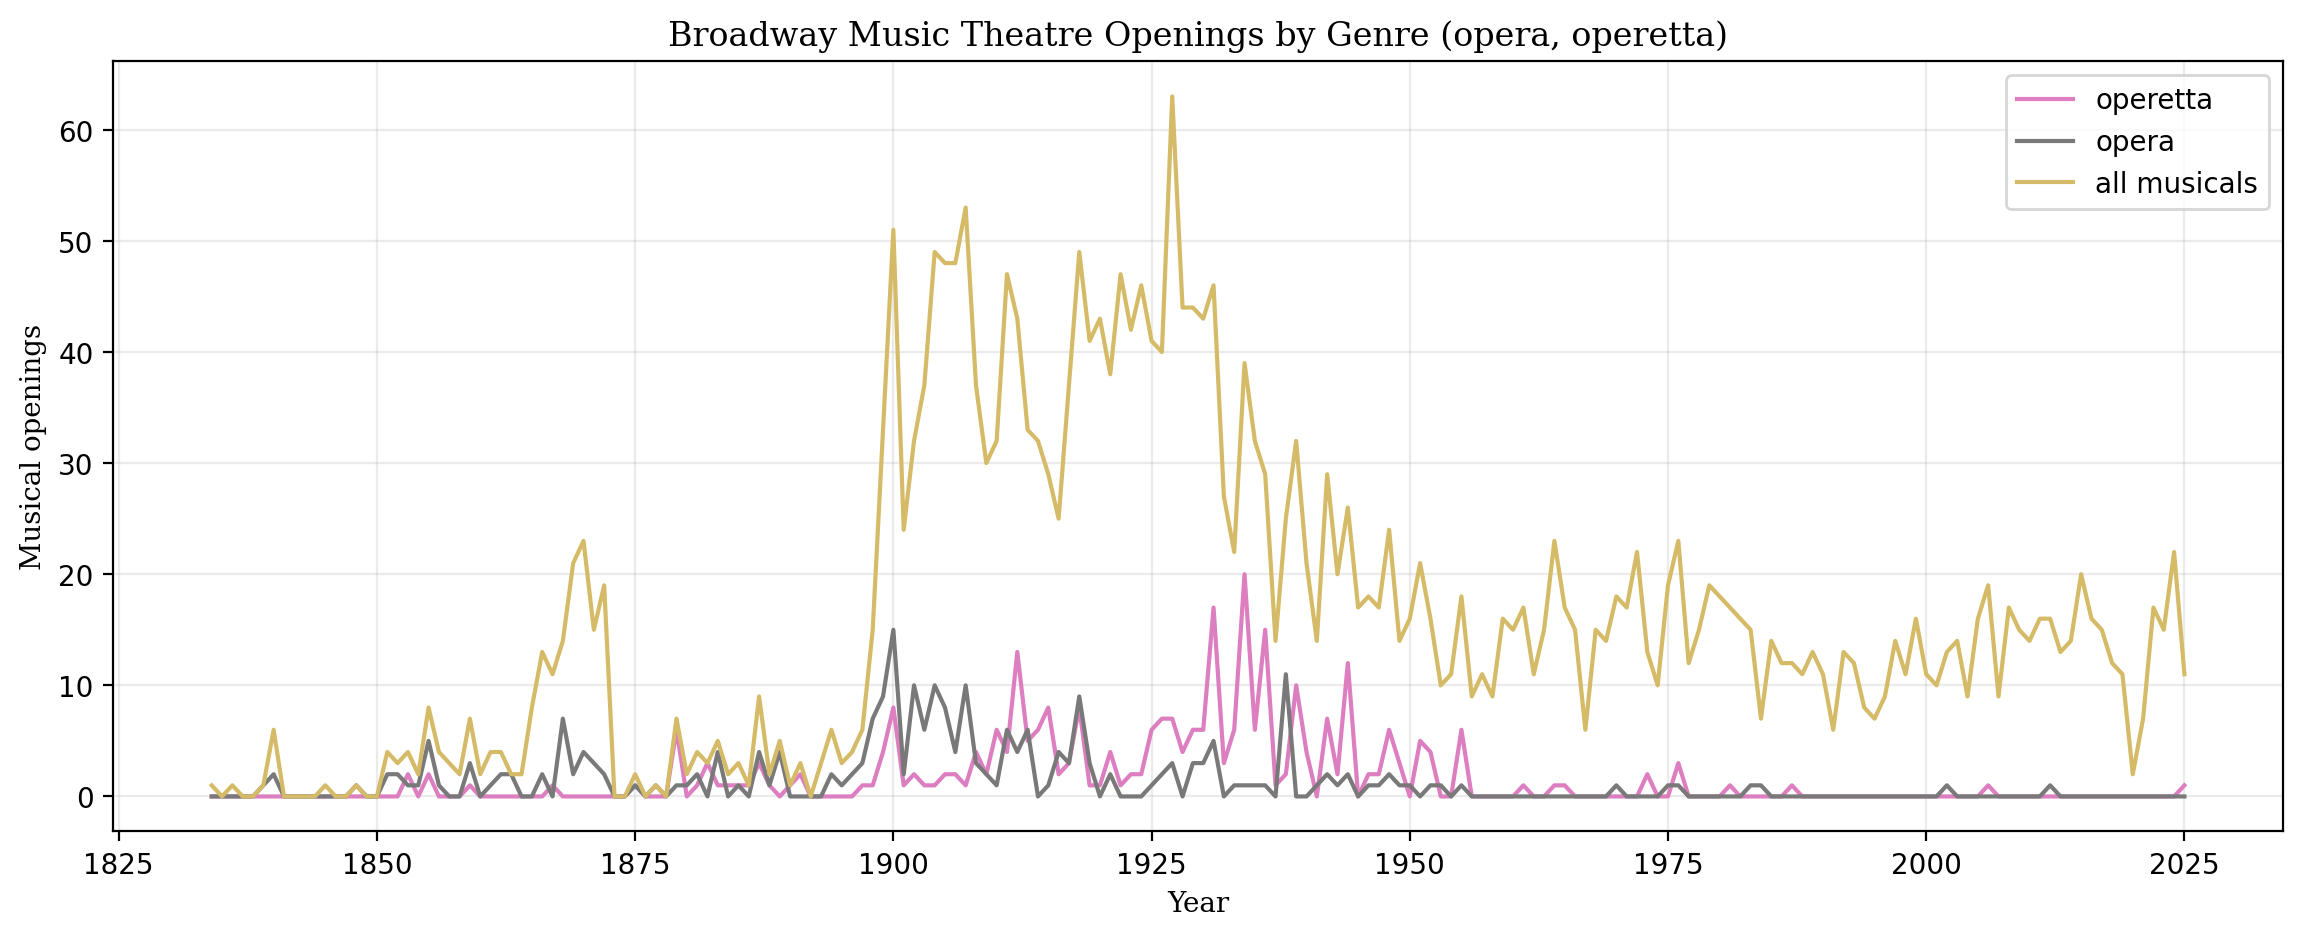

In [116]:
burlesque_df2 = burlesque_df1.reset_index()
minstrel_df2 = minstrel_df1.reset_index()
revue_df2 = revue_df1.reset_index()
extravaganza_df2 = extravaganza_df1.reset_index()
vaudeville_df2 = vaudeville_df1.reset_index()
variety_df2 = variety_df1.reset_index()

operetta_df2 = operetta_df1.reset_index()
opera_df2 = opera_df1.reset_index()
musical_df2 = musical_df1.reset_index()
comedy_df2 = comedy_df1.reset_index()

colors = sns.color_palette("muted", 10)
fig, ax = plt.subplots(figsize=(14, 5))


#ax.plot(burlesque_df2['opening_year'], burlesque_df2['count'], color=colors[0], label='burlesque')
#ax.plot(minstrel_df2['opening_year'], minstrel_df2['count'], color=colors[1], label='minstrel')
#ax.plot(revue_df2['opening_year'], revue_df2['count'], color=colors[2], label='revue')
#ax.plot(extravaganza_df2['opening_year'], extravaganza_df2['count'], color=colors[3], label='extravaganza')
#ax.plot(vaudeville_df2['opening_year'], vaudeville_df2['count'], color=colors[4], label='vaudeville')
#ax.plot(variety_df2['opening_year'], variety_df2['count'], color=colors[5], label='variety')
ax.plot(operetta_df2['opening_year'], operetta_df2['count'], color=colors[6], label='operetta')
ax.plot(opera_df2['opening_year'], opera_df2['count'], color=colors[7], label='opera')
ax.plot(musical_df2['opening_year'], musical_df2['count'], color=colors[8], label='all musicals')
#ax.plot(comedy_df2['opening_year'], comedy_df2['count'], color=colors[9], label='comedy')


plt.grid(alpha=0.25) # add a grid
plt.title('Broadway Music Theatre Openings by Genre (opera, operetta)', fontfamily="serif") # add a title
plt.xlabel('Year', fontfamily="serif")
plt.ylabel('Musical openings', fontfamily="serif")
plt.legend()
plt.show()


In [62]:
variety_df2
for key, value in variety_df2.iterrows():
    if value['count']>0:
        print(key)

105
118
147
157


Originals and revivals:

Next I want to figure out how long it takes for a show to get a revival

Get all stage works, convert date strings to datetime objects:

In [63]:
query2 = "SELECT * FROM stage_work"
stage_df = pd.read_sql_query(query2, con=connection)
stage_df['opening_date'] = pd.to_datetime(stage_df['opening_date'])
stage_df['closing_date'] = pd.to_datetime(stage_df['closing_date'])
stage_df['opening_year'] = stage_df['opening_date'].apply(take_year)
stage_df['preview_start_date'] = pd.to_datetime(stage_df['preview_start_date'])

query3 = "SELECT DISTINCT property_id FROM stage_work"
property_df = pd.read_sql_query(query3, con=connection)

C:\Users\12676\AppData\Local\Temp\ipykernel_22040\1395782140.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stage_df = pd.read_sql_query(query2, con=connection)
C:\Users\12676\AppData\Local\Temp\ipykernel_22040\1395782140.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  property_df = pd.read_sql_query(query3, con=connection)


Count overlap between genres:

In [64]:
# make a 10x10 mtx. order: [burlesque, comedy, extravaganza, minstrel, opera, operetta, revue, variety, vaudeville]
overlap_mtx = []
i=0
while i<9:
    overlap_mtx.append([0]*9)
    i+=1
indices = ['burlesque', 'comedy', 'extravaganza', 'minstrel', 'opera', 'operetta', 'revue', 'variety', 'vaudeville']
dfs = [burlesque_df, comedy_df, extravaganza_df, minstrel_df, opera_df, operetta_df, revue_df, variety_df, vaudeville_df]
for key, row in stage_df.iterrows():
    i=0
    work_id = row['work_id']
    while i<9:
        j=0
        while j<9:
            if dfs[i]['work_id'].eq(work_id).any() and dfs[j]['work_id'].eq(work_id).any():
                overlap_mtx[i][j] +=1
            j+=1
        i+=1
print(np.array2string(np.array(overlap_mtx), separator=' '))


[[ 111    7   25    1    4    0    2    0    4]
 [   7 1212    8    1  130   78   16    1    3]
 [  25    8   95    0    1    0    9    0    2]
 [   1    1    0    6    0    0    0    0    1]
 [   4  130    1    0  251    0    0    0    0]
 [   0   78    0    0    0  305    0    0    0]
 [   2   16    9    0    0    0  463    0   17]
 [   0    1    0    0    0    0    0    4    0]
 [   4    3    2    1    0    0   17    0   46]]


Make a heatmap from this!

<Axes: >

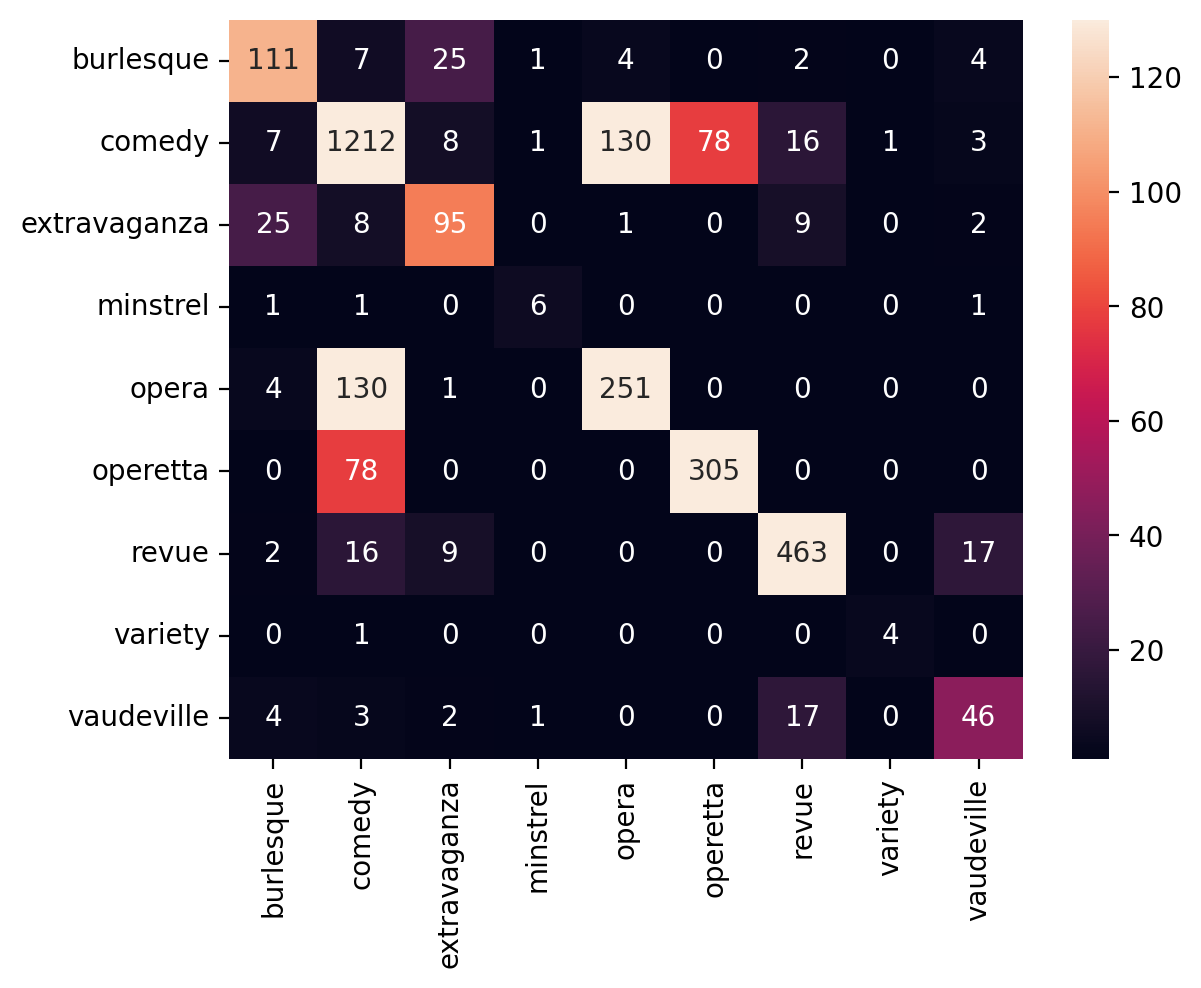

In [65]:
#no_diag_mtx = np.diagonal(overlap_mtx,)
#mask = np.eye(np.array(overlap_mtx).shape[0], dtype=bool)  # Create a diagonal mask

labels = ['burlesque', 'comedy', 'extravaganza', 'minstrel', 'opera', 'operetta', 'revue', 'variety', 'vaudeville']
sns.heatmap(overlap_mtx, annot=True, xticklabels=labels, yticklabels=labels, vmin=1, vmax=130, fmt=".0f")

Originals and revivals:

     opening_year  og_count  revival_count  og_norm_counts  \
0          1852.0         2              1        0.666667   
1          1853.0         3              1        0.750000   
2          1854.0         1              1        0.500000   
3          1855.0         5              3        0.625000   
4          1856.0         3              1        0.750000   
..            ...       ...            ...             ...   
132        2021.0         4              2        0.571429   
133        2022.0        10              4        0.588235   
134        2023.0         9              6        0.600000   
135        2024.0        15              7        0.681818   
136        2025.0        10              1        0.909091   

     revival_norm_counts  
0               0.333333  
1               0.250000  
2               0.500000  
3               0.375000  
4               0.250000  
..                   ...  
132             0.285714  
133             0.235294  
134         

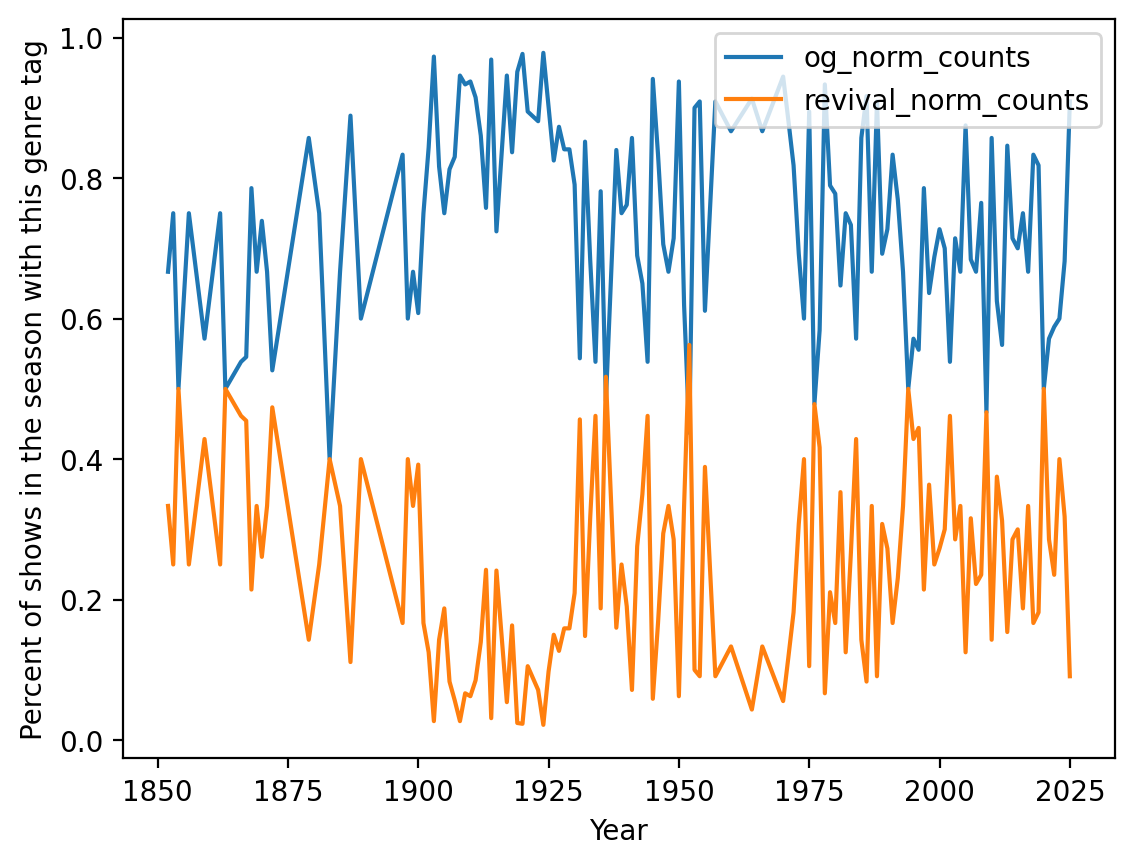

In [66]:
def norm_against_totals_1(row):
    year = row['opening_year']
    og_count = row['og_count']
    year_total = overall_value_counts[year]
    return (og_count / year_total)

def norm_against_totals_2(row):
    year = row['opening_year']
    rev_count = row['revival_count']
    year_total = overall_value_counts[year]
    return (rev_count / year_total)

original_df = stage_df[stage_df['type_id']=='11']
revival_df = stage_df[stage_df['type_id']=='12']
rtn_engagement_df = stage_df[stage_df['type_id']=='14']

# original_df = tags_df[tags_df['tag_name']=='Original']
# revival_df = tags_df[tags_df['tag_name']=='Revival']

original_counts = pd.DataFrame(original_df['opening_year'].value_counts().sort_index())
original_counts.columns = ['og_count']
revival_counts = pd.DataFrame(revival_df['opening_year'].value_counts().sort_index())
revival_counts.columns = ['revival_count']
og_revival_counts = pd.merge(original_counts, revival_counts, left_index=True, right_index=True)
og_revival_counts = og_revival_counts.reset_index()
og_revival_counts['og_norm_counts'] = og_revival_counts.apply(norm_against_totals_1, axis=1)
og_revival_counts['revival_norm_counts'] = og_revival_counts.apply(norm_against_totals_2, axis=1)
print(og_revival_counts)

#og_revival_counts.plot(x='opening_year', y='og_norm_counts')
og_revival_counts.plot(x='opening_year', y=['og_norm_counts','revival_norm_counts'])
plt.xlabel("Year")
plt.ylabel("Percent of shows in the season with this genre tag")
plt.show()

For each property_id, we want to get the date of the original and the first revival.

In [67]:
# Let's make a nested dictionary. 
# Keys are property_ids. Value is a dictionary, whose values are the work_id of the original, and a list of the work_ids of all revivals
# in the 'og_work_id' column I want to put the work_id of the production with the SAME property_id, who has the tag 'original'
property_df = pd.merge(property_df, original_df, on='property_id',how='inner')[['property_id', 'work_id', 'opening_date', 'closing_date', 'opening_year']]
property_df.columns = ['property_id', 'og_work_id', 'og_opening_date', 'og_closing_date', 'og_opening_year']
property_df

,property_id,og_work_id,og_opening_date,og_closing_date,og_opening_year
0,0000,00000011,1899-11-06,1900-02-24,1899.0
1,0001,00010011,1966-03-29,1966-07-17,1966.0
2,0002,00020011,1912-11-20,1913-01-25,1912.0
3,0003,00030011,2008-07-17,2008-10-12,2008.0
4,0004,00040011,2022-11-17,NaT,2022.0
...,...,...,...,...,...
2451,2581,25810011,1994-05-10,1994-05-22,1994.0
2452,2582,25820011,1930-09-23,1931-05-02,1930.0
2453,2583,25830011,1923-01-24,1923-05-12,1923.0
2454,2584,25840011,1922-09-20,1922-12-02,1922.0


Now get the info about the first revival

In [68]:
revival_df
# this keeps only the rows who have the earlier opening year of the ones with the shared property id.
first_rev_df = revival_df.loc[revival_df.groupby('property_id')['opening_year'].idxmin()]
property_df = pd.merge(property_df, first_rev_df, on='property_id',how='inner')[['property_id', 'og_work_id', 'og_opening_date', 'og_closing_date', 'og_opening_year', 'work_id', 'opening_date', 'closing_date', 'opening_year']]
property_df.columns = ['property_id', 'og_work_id', 'og_opening_date', 'og_closing_date', 'og_opening_year', 'first_rev_work_id', 'first_rev_opening_date', 'first_rev_closing_date', 'first_rev_opening_year']
property_df

,property_id,og_work_id,og_opening_date,og_closing_date,og_opening_year,first_rev_work_id,first_rev_opening_date,first_rev_closing_date,first_rev_opening_year
0,0005,00050011,1963-10-24,1964-08-08,1963.0,00050012,2007-05-09,2007-07-29,2007.0
1,0010,00100111,1969-03-16,1972-02-13,1969.0,00100012,1997-08-14,1998-06-14,1997.0
2,0014,00140111,1980-08-25,1989-01-08,1980.0,00140012,2001-05-02,2005-01-02,2001.0
3,0028,00280111,1902-06-02,1903-04-25,1902.0,00280012,1904-03-28,1904-04-02,1904.0
4,0029,00290111,1975-07-25,1990-04-28,1975.0,00290012,2006-10-05,2008-08-17,2006.0
...,...,...,...,...,...,...,...,...,...
216,2512,25120111,1928-12-04,1929-11-23,1928.0,25120012,1979-02-14,1979-08-12,1979.0
217,2529,25290111,1953-02-25,1954-07-03,1953.0,25290012,2003-11-23,2005-01-30,2003.0
218,2545,25450111,1971-06-01,1971-06-27,1971.0,25450012,1999-02-04,1999-06-13,1999.0
219,2550,25500011,1927-01-25,1927-05-14,1927.0,25500112,1928-03-12,1928-03-01,1928.0


Now let's try to plot first revival against original:

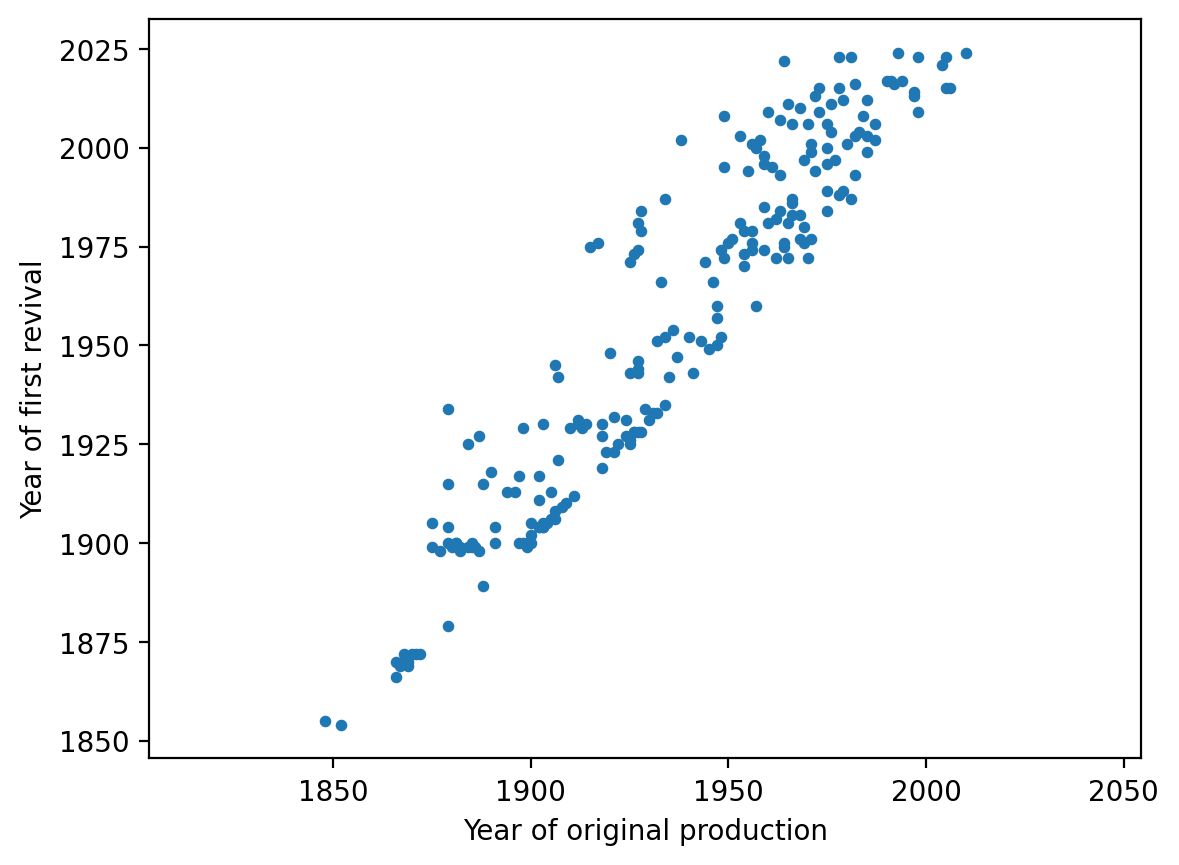

In [69]:
#property_df.plot(x='og_opening_year', y='first_rev_opening_year')
# changing the size of s changes the size of the dots. the default size is 100
plt.scatter(property_df['og_opening_year'], property_df['first_rev_opening_year'], s=10)
plt.axis('equal')
plt.xlabel('Year of original production')
plt.ylabel('Year of first revival')
plt.show()

# og_revival_counts.plot(x='opening_year', y=['og_norm_counts','revival_norm_counts'])
# plt.xlabel("Year")
# plt.ylabel("Percent of shows in the season with this genre tag")
# plt.show()

In [70]:
#print(property_df)
# from IPython.display import display
# display(property_df)
stage_df

,work_id,property_id,type_id,title,ibdb_url,opening_date,preview_start_date,closing_date,opening_year
0,00000011,0000,11,'Round New York in 80 Minutes,/broadway-production/round-new-york-in-80-minu...,1899-11-06,NaT,1900-02-24,1899.0
1,00010011,0001,11,"""It's a Bird...It's a Plane...It's Superman""",/broadway-production/its-a-birdits-a-planeits-...,1966-03-29,1966-03-09,1966-07-17,1966.0
2,00020011,0002,11,(From) Broadway to Paris,/broadway-production/from-broadway-to-paris-7525,1912-11-20,NaT,1913-01-25,1912.0
3,00030011,0003,11,[title of show],/broadway-production/title-of-show-478457,2008-07-17,2008-07-05,2008-10-12,2008.0
4,00040011,0004,11,& Juliet,/broadway-production/-juliet-534962,2022-11-17,2022-10-28,NaT,2022.0
...,...,...,...,...,...,...,...,...,...
3092,25810011,2581,11,The Best Little Whorehouse Goes Public,/broadway-production/the-best-little-whorehous...,1994-05-10,1994-04-14,1994-05-22,1994.0
3093,25820011,2582,11,Fine and Dandy,/broadway-production/fine-and-dandy-9442,1930-09-23,NaT,1931-05-02,1930.0
3094,25830011,2583,11,The Dancing Girl,/broadway-production/the-dancing-girl-9195,1923-01-24,NaT,1923-05-12,1923.0
3095,25840011,2584,11,The Passing Show of 1922,/broadway-production/the-passing-show-of-1922-...,1922-09-20,NaT,1922-12-02,1922.0


In [71]:
property_dict = {}
for index, row in stage_df.iterrows():
    curr_prop = row['property_id']
    if curr_prop not in property_dict:
        #property_dict.update({property_dict:{"original": '', "revivals": []}})
        property_dict[curr_prop]= {"original": '', "revivals": []}
    if row['type_id'] == '11':
        #print(property_dict[curr_prop])
        property_dict[curr_prop]["original"] = row['work_id']
    elif row['type_id']=='12':
        property_dict[curr_prop]["revivals"].append(row['work_id'])
    
no_og = []
for key,value in property_dict.items():
    if value['original']=='':
        work_id = value["revivals"][0]
        index = stage_df.index[stage_df['work_id']==work_id].tolist()[0]
        row = stage_df.iloc[index]['opening_year']
        if row>1930:
            no_og.append(key)

no_og


['0075',
 '0148',
 '0431',
 '0433',
 '0486',
 '0715',
 '1293',
 '1795',
 '1818',
 '1825',
 '2018',
 '2078',
 '2113',
 '2145',
 '2179',
 '2424',
 '2433',
 '2438',
 '2515']

In [72]:
#stage_df.to_csv('3.21_all_stage_works.csv', index=False)

I'd like to replot original versus revival, but now have ALL revivals, not just first revivals.

In [73]:
all_revivals_df = pd.merge(revival_df, original_df, on='property_id',how='inner')
all_revivals_df.columns = ['rev_work_id', 'rev_property_id','rev_type_id', 'rev_title', 'rev_ibdb_url', 'rev_opening_date', 'rev_preview_start_date', 'rev_closing_date', 'rev_opening_year', 'og_work_id', 'og_type_id', 'og_title', 'og_ibdb_url', 'og_opening_date', 'og_preview_start_date', 'og_closing_date', 'og_opening_year']
all_revivals_df

,rev_work_id,rev_property_id,rev_type_id,rev_title,rev_ibdb_url,rev_opening_date,rev_preview_start_date,rev_closing_date,rev_opening_year,og_work_id,og_type_id,og_title,og_ibdb_url,og_opening_date,og_preview_start_date,og_closing_date,og_opening_year
0,00050012,0005,12,110 in the Shade,/broadway-production/110-in-the-shade-423558,2007-05-09,2007-04-13,2007-07-29,2007.0,00050011,11,110 in the Shade,/broadway-production/110-in-the-shade-3037,1963-10-24,1963-10-23,1964-08-08,1963.0
1,00100012,0010,12,1776,/broadway-production/1776-4754,1997-08-14,1997-07-16,1998-06-14,1997.0,00100111,11,1776,/broadway-production/1776-2859,1969-03-16,1969-03-12,1972-02-13,1969.0
2,00100212,0010,12,1776,/broadway-production/1776-534848,2022-10-06,2022-09-16,2023-01-08,2022.0,00100111,11,1776,/broadway-production/1776-2859,1969-03-16,1969-03-12,1972-02-13,1969.0
3,00140012,0014,12,42nd Street,/broadway-production/42nd-street-12864,2001-05-02,2001-04-04,2005-01-02,2001.0,00140111,11,42nd Street,/broadway-production/42nd-street-3963,1980-08-25,1980-08-18,1989-01-08,1980.0
4,00280012,0028,12,A Chinese Honeymoon,/broadway-production/a-chinese-honeymoon-5599,1904-03-28,NaT,1904-04-02,1904.0,00280111,11,A Chinese Honeymoon,/broadway-production/a-chinese-honeymoon-5598,1902-06-02,NaT,1903-04-25,1902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,25120012,2512,12,Whoopee!,/broadway-production/whoopee-3920,1979-02-14,1979-02-08,1979-08-12,1979.0,25120111,11,Whoopee!,/broadway-production/whoopee-10796,1928-12-04,NaT,1929-11-23,1928.0
484,25290012,2529,12,Wonderful Town,/broadway-production/wonderful-town-13560,2003-11-23,2003-11-05,2005-01-30,2003.0,25290111,11,Wonderful Town,/broadway-production/wonderful-town-2221,1953-02-25,NaT,1954-07-03,1953.0
485,25450012,2545,12,"You're a Good Man, Charlie Brown",/broadway-production/youre-a-good-man-charlie-...,1999-02-04,1999-01-23,1999-06-13,1999.0,25450111,11,"You're a Good Man, Charlie Brown",/broadway-production/youre-a-good-man-charlie-...,1971-06-01,1971-05-21,1971-06-27,1971.0
486,25500112,2550,12,Yours Truly,/broadway-production/yours-truly-10604,1928-03-12,NaT,1928-03-01,1928.0,25500011,11,Yours Truly,/broadway-production/yours-truly-10217,1927-01-25,NaT,1927-05-14,1927.0


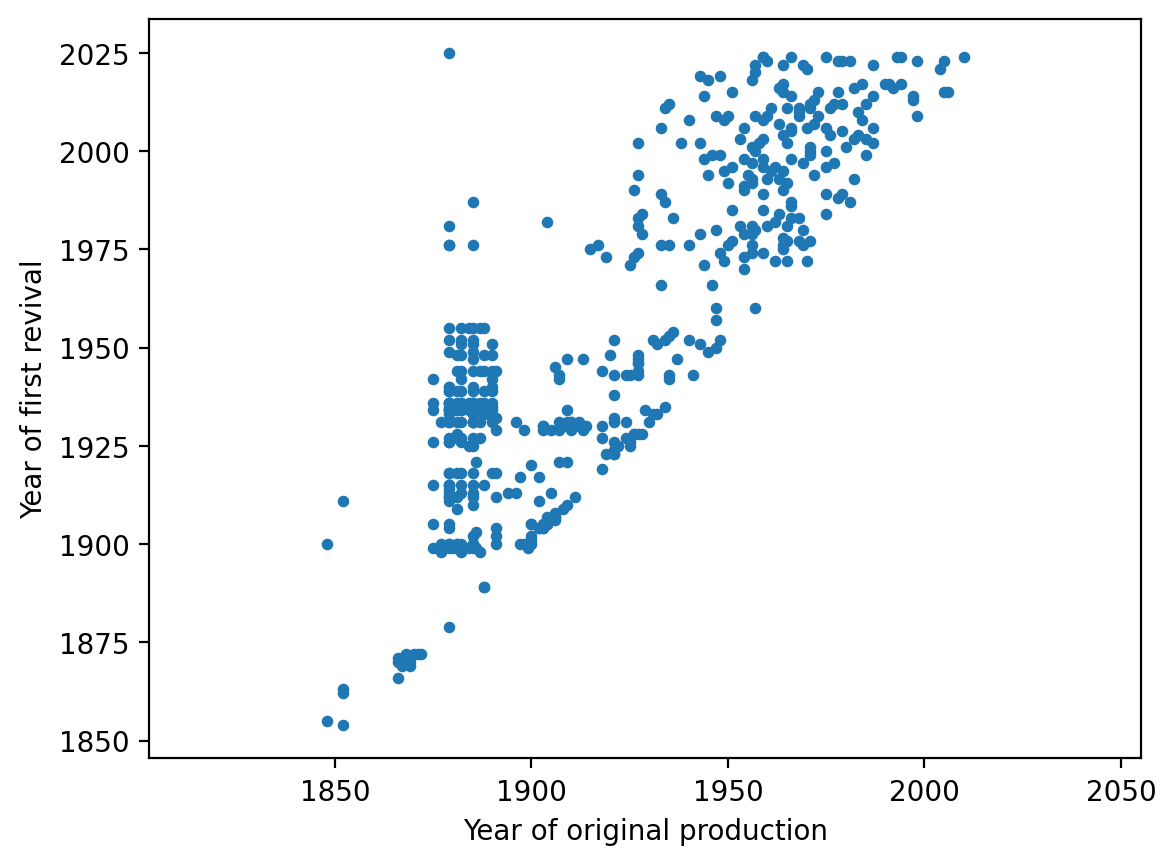

In [74]:
plt.scatter(all_revivals_df['og_opening_year'], all_revivals_df['rev_opening_year'], s=10)
plt.axis('equal')
plt.xlabel('Year of original production')
plt.ylabel('Year of first revival')
plt.show()

Let's make a boxplot to see how this range of original years has changed each year.

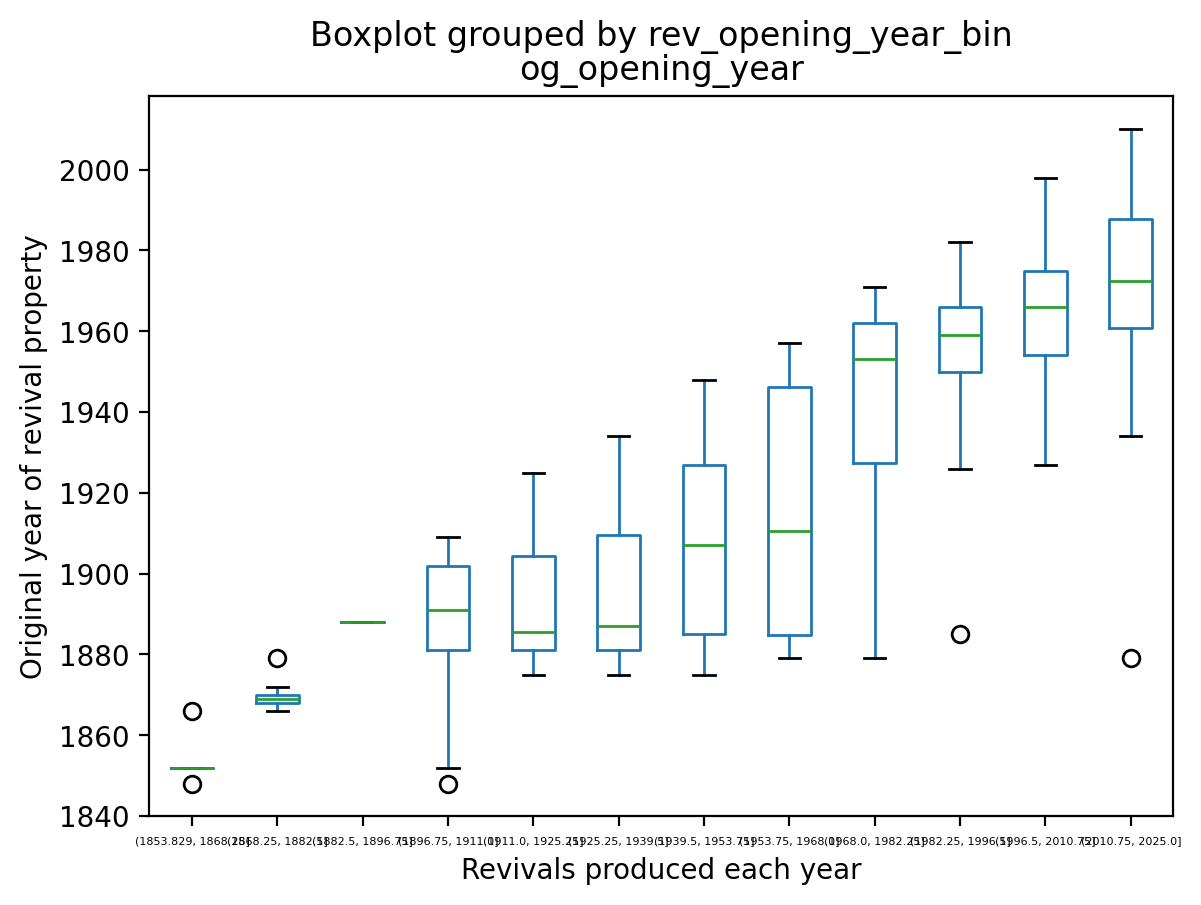

In [75]:
#all_revivals_df
binned_all_revivals_df = all_revivals_df.copy()
binned_all_revivals_df['og_opening_year_bin'] = pd.cut(binned_all_revivals_df['og_opening_year'], bins=8)
binned_all_revivals_df['og_opening_year_bin']=binned_all_revivals_df['og_opening_year_bin'].astype(str) 
binned_all_revivals_df['rev_opening_year_bin'] = pd.cut(binned_all_revivals_df['rev_opening_year'], bins=12)
binned_all_revivals_df['rev_opening_year_bin']=binned_all_revivals_df['rev_opening_year_bin'].astype(str)
binned_all_revivals_df.boxplot(column='og_opening_year', by='rev_opening_year_bin', grid=False)
plt.xlabel('Revivals produced each year')
plt.xticks(fontsize=4)
plt.ylabel('Original year of revival property')
plt.show()

Bin instead according to Miller's binning in avg broadway

<Figure size 1200x500 with 0 Axes>

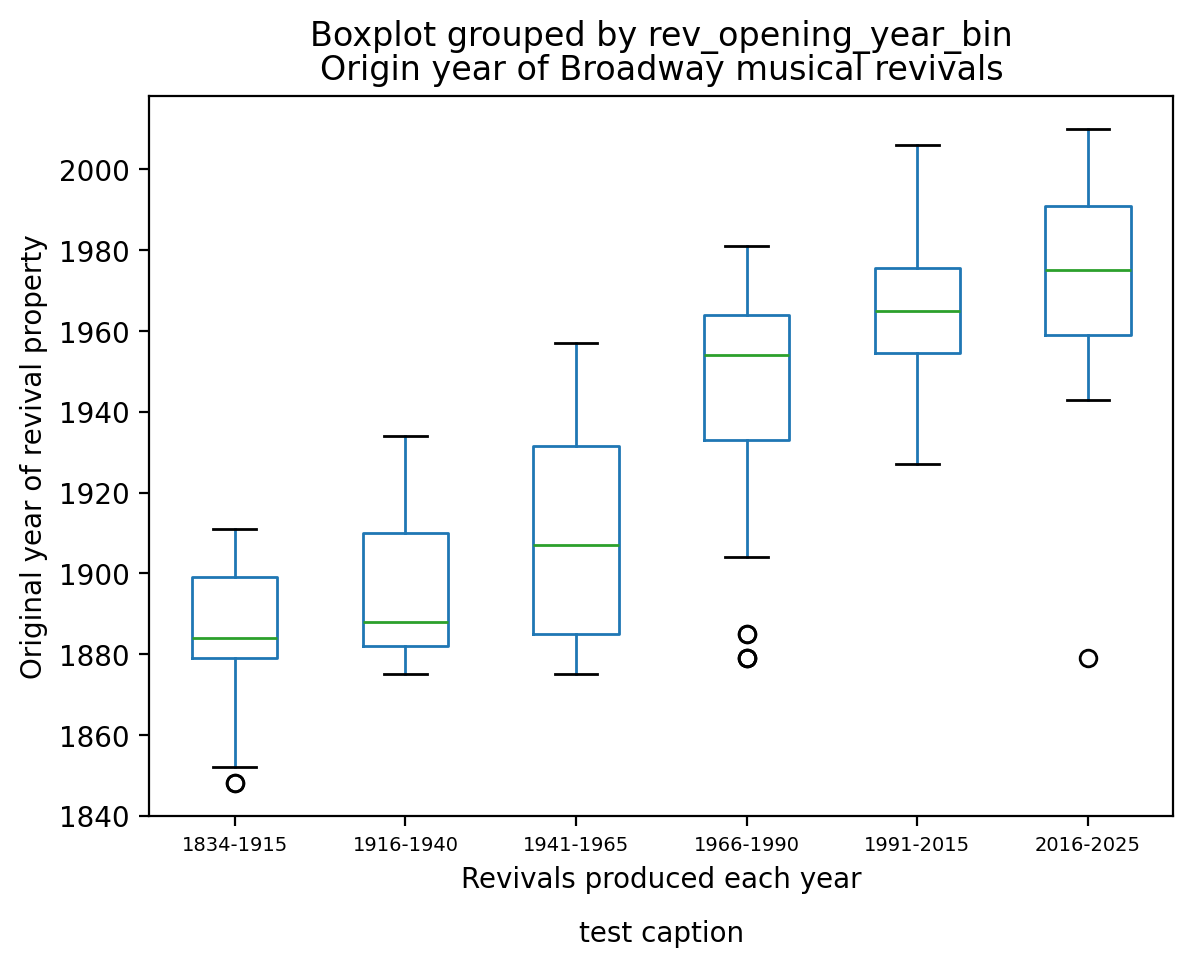

In [76]:
bins = [1834, 1915, 1940, 1965, 1990, 2015, 2025]
bin_labels = ['1834-1915', '1916-1940', '1941-1965', '1966-1990', '1991-2015', '2016-2025']

binned_all_revivals_df1 = all_revivals_df.copy()
binned_all_revivals_df1['og_opening_year_bin'] = pd.cut(binned_all_revivals_df1['og_opening_year'], bins=bins, labels=bin_labels, include_lowest=True)
binned_all_revivals_df1['og_opening_year_bin']=binned_all_revivals_df1['og_opening_year_bin'].astype(str) 
binned_all_revivals_df1['rev_opening_year_bin'] = pd.cut(binned_all_revivals_df1['rev_opening_year'], bins=bins, labels=bin_labels, include_lowest=True)
binned_all_revivals_df1['rev_opening_year_bin']=binned_all_revivals_df1['rev_opening_year_bin'].astype(str)
plt.figure(figsize=(12,5))
binned_all_revivals_df1.boxplot(column='og_opening_year', by='rev_opening_year_bin', grid=False)
plt.xlabel('Revivals produced each year')
plt.xticks(fontsize=7)
plt.ylabel('Original year of revival property')
plt.figtext(0.5, 0.02, "test caption", ha='center', fontsize=10)
plt.title("Origin year of Broadway musical revivals")
plt.show()

Let's try making this in seaborn, which is allegedly easier to work with.

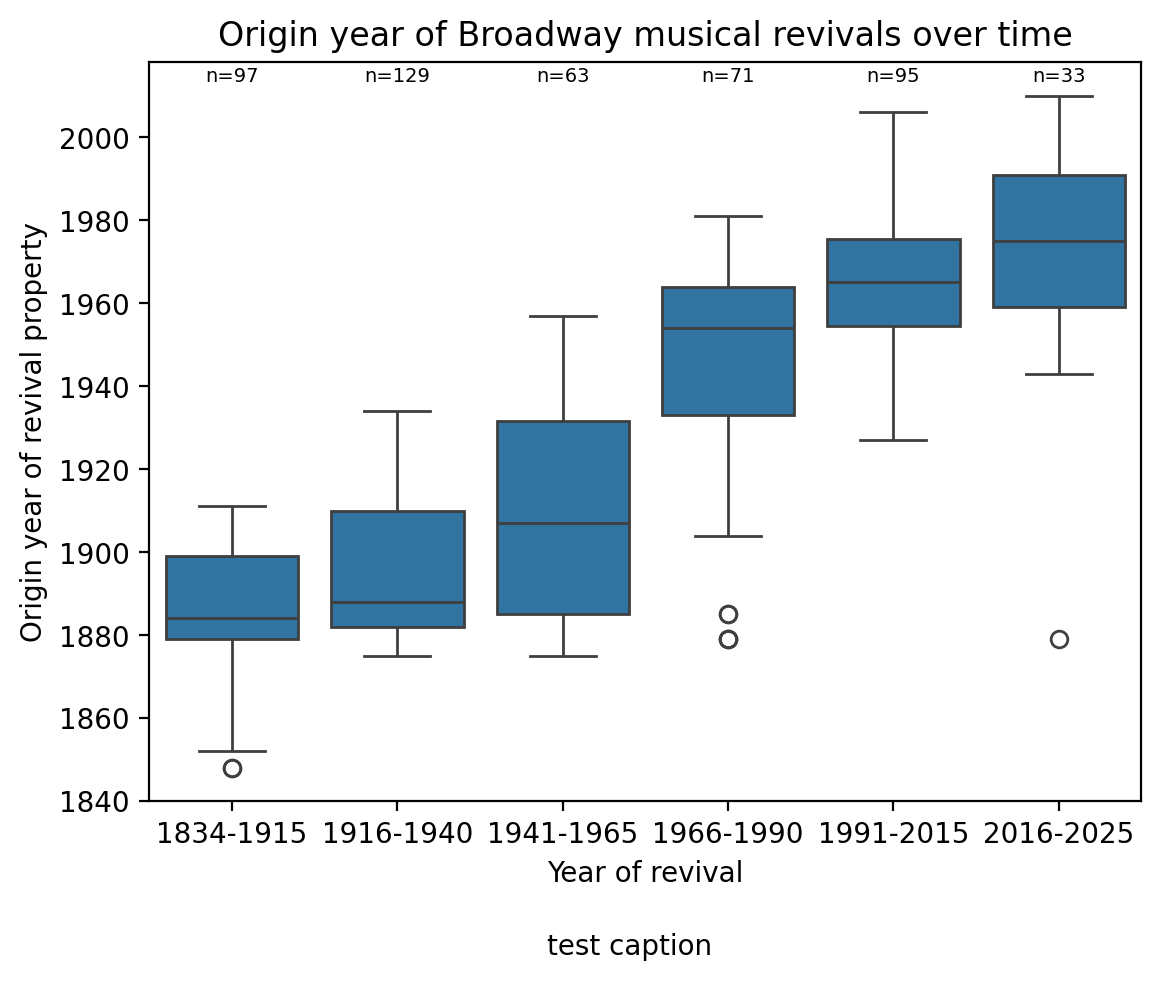

In [ ]:
ax = sns.boxplot(x='rev_opening_year_bin', y='og_opening_year', data=binned_all_revivals_df1, order=bin_labels)
plt.xlabel('Year of revival')
plt.ylabel('Origin year of revival property')
plt.figtext(0.5, -0.05, "test caption", ha='center', fontsize=10)
plt.title("Origin year of Broadway musical revivals over time")

# this code is written by ChatGPT and puts the value counts of each bin above the box.
counts1 = binned_all_revivals_df1['rev_opening_year_bin'].value_counts()
for i, category in enumerate(bin_labels):
    count = counts1[category] if category in counts1 else 0  # Get count or default to 0
    ax.annotate(f'n={count}', xy=(i, binned_all_revivals_df1['og_opening_year'].max()), xytext=(0,5), 
                textcoords="offset points", ha='center', fontsize=7, color="black")
plt.show()
# this is close right now but it's in reverse ordder and is missing 2015-2025

Let's try to re-make this same graph, but instead bin by decade.

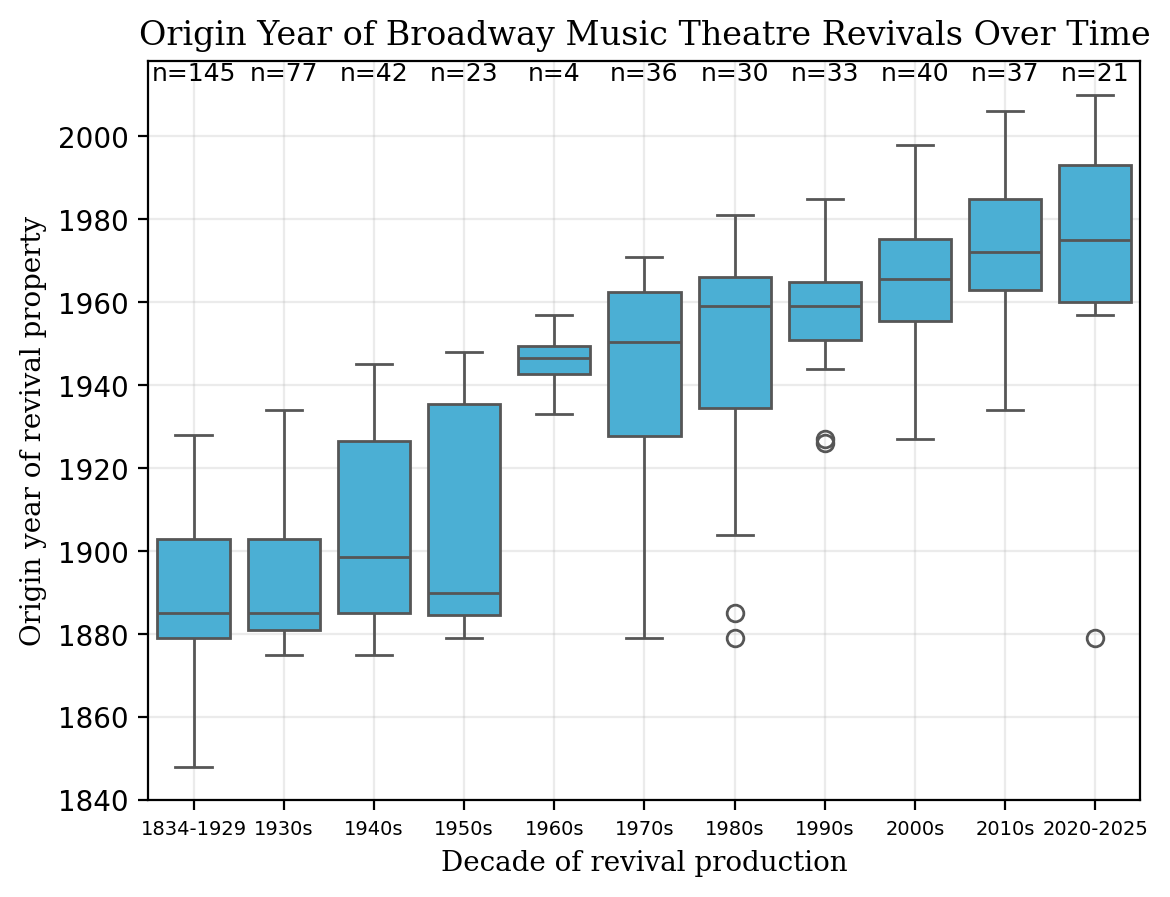

In [113]:
bins3 = [1834, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2025]
bin_labels3 = ['1834-1929', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020-2025']

binned_all_revivals_df3 = all_revivals_df.copy()
binned_all_revivals_df3['og_opening_year_bin'] = pd.cut(binned_all_revivals_df3['og_opening_year'], bins=bins3, labels=bin_labels3, include_lowest=True)
binned_all_revivals_df3['og_opening_year_bin']=binned_all_revivals_df3['og_opening_year_bin'].astype(str) 
binned_all_revivals_df3['rev_opening_year_bin'] = pd.cut(binned_all_revivals_df3['rev_opening_year'], bins=bins3, labels=bin_labels3, include_lowest=True)
binned_all_revivals_df3['rev_opening_year_bin']=binned_all_revivals_df3['rev_opening_year_bin'].astype(str)

ax = sns.boxplot(x='rev_opening_year_bin', y='og_opening_year', data=binned_all_revivals_df3, order=bin_labels3, color="#34baeb")
plt.xlabel('Decade of revival production', fontfamily="serif")
plt.xticks(fontsize=7)
plt.grid(alpha=0.25)
plt.ylabel('Origin year of revival property', fontfamily="serif")
#plt.figtext(0.5, -0.05, "test caption", ha='center', fontsize=10, fontfamily="serif")
plt.title("Origin Year of Broadway Music Theatre Revivals Over Time", fontfamily="serif")

# this code is written by ChatGPT and puts the value counts of each bin above the box.
counts3 = binned_all_revivals_df3['rev_opening_year_bin'].value_counts()
for i, category in enumerate(bin_labels3):
    count = counts3[category] if category in counts3 else 0  # Get count or default to 0
    ax.annotate(f'n={count}', xy=(i, binned_all_revivals_df3['og_opening_year'].max()), xytext=(0,5), 
                textcoords="offset points", ha='center', fontsize=9, color="black")
plt.show()

Let's make another version of this that does go strictly by decade:

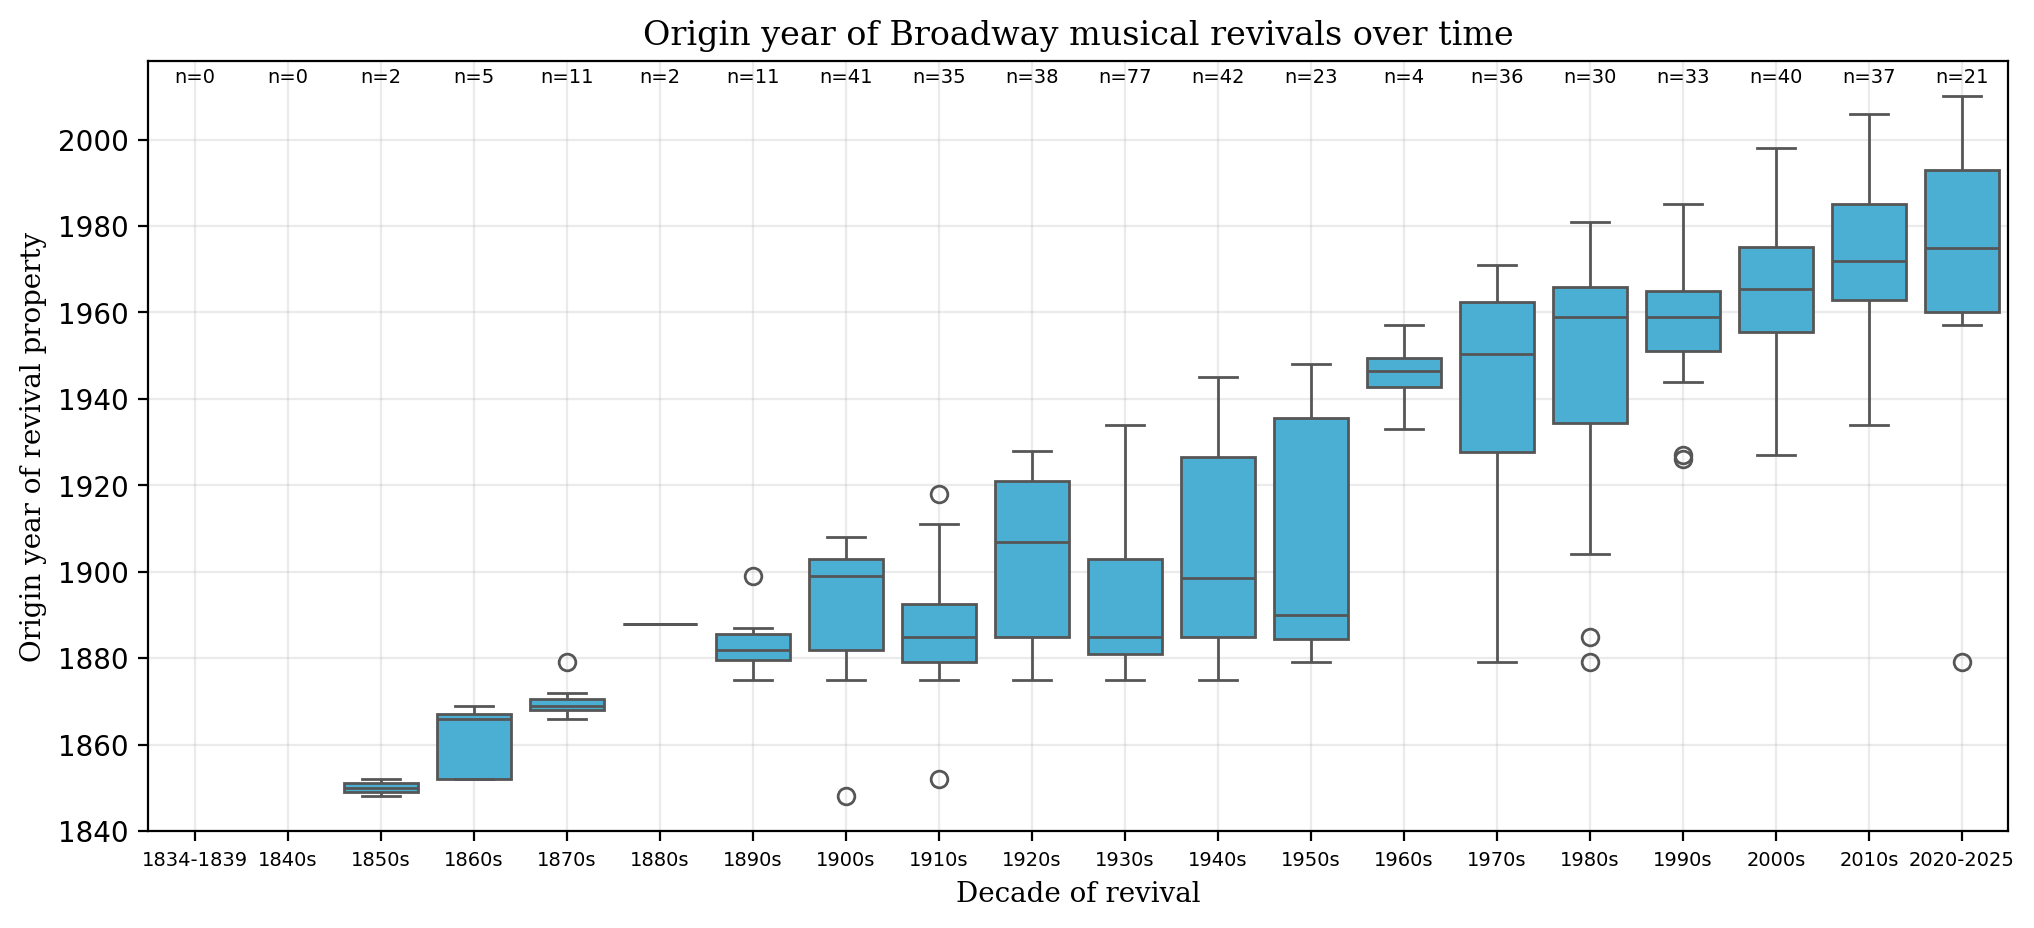

In [79]:
bins4 = [1834, 1839, 1849, 1859, 1869, 1879, 1889, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2025]
bin_labels4 = ['1834-1839', '1840s', '1850s', '1860s', '1870s', '1880s', '1890s', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020-2025']


binned_all_revivals_df31 = all_revivals_df.copy()
binned_all_revivals_df31['og_opening_year_bin'] = pd.cut(binned_all_revivals_df31['og_opening_year'], bins=bins4, labels=bin_labels4, include_lowest=True)
binned_all_revivals_df31['og_opening_year_bin']=binned_all_revivals_df31['og_opening_year_bin'].astype(str) 
binned_all_revivals_df31['rev_opening_year_bin'] = pd.cut(binned_all_revivals_df31['rev_opening_year'], bins=bins4, labels=bin_labels4, include_lowest=True)
binned_all_revivals_df31['rev_opening_year_bin']=binned_all_revivals_df31['rev_opening_year_bin'].astype(str)

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='rev_opening_year_bin', y='og_opening_year', data=binned_all_revivals_df31, order=bin_labels4, ax=ax, color="#34baeb")
plt.xlabel('Decade of revival', fontfamily="serif")
plt.xticks(fontsize=7)
plt.ylabel('Origin year of revival property', fontfamily="serif")
plt.grid(alpha=0.25)
#plt.figtext(0.5, -0.05, "test caption", ha='center', fontsize=10, fontfamily="serif") #this is for a caption
plt.title("Origin year of Broadway musical revivals over time", fontfamily="serif")

# this code is written by ChatGPT and puts the value counts of each bin above the box.
counts31 = binned_all_revivals_df31['rev_opening_year_bin'].value_counts()
for i, category in enumerate(bin_labels4):
    count = counts31[category] if category in counts31 else 0  # Get count or default to 0
    ax.annotate(f'n={count}', xy=(i, binned_all_revivals_df31['og_opening_year'].max()), xytext=(0,5), 
                textcoords="offset points", ha='center', fontsize=7, color="black")
plt.show()

Use this code to examine which shows were revived in each bin:

In [80]:
for key, value in binned_all_revivals_df3.iterrows():
    if value['rev_opening_year_bin']=='1990s':
        print(value['rev_title'])

1776
A Funny Thing Happened on the Way to the Forum
Annie
Annie Get Your Gun
Cabaret
Camelot
Candide
Carousel
Chicago
Damn Yankees
Fiddler on the Roof
Gentlemen Prefer Blondes
Grease
Guys and Dolls
Hello, Dolly!
How to Succeed in Business Without Really Trying
Joseph and the Amazing Technicolor Dreamcoat
Kiss Me, Kate
Man of La Mancha
My Fair Lady
Oh, Kay!
On the Town
Once Upon a Mattress
Peter Pan
Peter Pan
Peter Pan
She Loves Me
Show Boat
Tango Argentino
The King and I
The Most Happy Fella
The Sound of Music
You're a Good Man, Charlie Brown


I now want to look at revivals WITHOUT non-MT genres. Let's remove everything that is opera, operetta, etc. Also things that are pre-Showboat or originally pre-Show boat

In [ ]:
tags_to_remove = ['Opera', 'Operetta', 'Revue', 'Extravaganza', 'Vaudeville', 'Burlesque', 'Minstrel', 'Variety', 'Ballet'] # continue updating this
ids_to_remove = set()
properties_to_remove = set()
tags_df
# remove things by tag
for key, row in tags_df.iterrows():
    if row['work_id'] in ids_to_remove:
        continue
    if row['property_id'] in properties_to_remove:
        ids_to_remove.add(row['work_id'])
    if row['tag_name'] in tags_to_remove:
        ids_to_remove.add(row['work_id'])
        properties_to_remove.add(row['property_id'])

# remove things that are pre-Show Boat or are not like this

strict_revivals_df = pd.DataFrame(columns=all_revivals_df.columns.tolist())
#strict_musicals_df.columns = musical_df.columns.tolist()
for key, row in all_revivals_df.iterrows():
    if row['rev_work_id'] not in ids_to_remove:
        strict_revivals_df.loc[len(strict_revivals_df)]=row

# strict_revivals_df['type_id'] = strict_revivals_df['work_id'].astype(str)
# strict_revivals_df['type_id'] = strict_revivals_df['type_id'].str.slice(6,)
strict_revivals_df


,rev_work_id,rev_property_id,rev_type_id,rev_title,rev_ibdb_url,rev_opening_date,rev_preview_start_date,rev_closing_date,rev_opening_year,og_work_id,og_type_id,og_title,og_ibdb_url,og_opening_date,og_preview_start_date,og_closing_date,og_opening_year
0,00050012,0005,12,110 in the Shade,/broadway-production/110-in-the-shade-423558,2007-05-09 00:00:00,2007-04-13 00:00:00,2007-07-29 00:00:00,2007.0,00050011,11,110 in the Shade,/broadway-production/110-in-the-shade-3037,1963-10-24 00:00:00,1963-10-23 00:00:00,1964-08-08 00:00:00,1963.0
1,00100012,0010,12,1776,/broadway-production/1776-4754,1997-08-14 00:00:00,1997-07-16 00:00:00,1998-06-14 00:00:00,1997.0,00100111,11,1776,/broadway-production/1776-2859,1969-03-16 00:00:00,1969-03-12 00:00:00,1972-02-13 00:00:00,1969.0
2,00100212,0010,12,1776,/broadway-production/1776-534848,2022-10-06 00:00:00,2022-09-16 00:00:00,2023-01-08 00:00:00,2022.0,00100111,11,1776,/broadway-production/1776-2859,1969-03-16 00:00:00,1969-03-12 00:00:00,1972-02-13 00:00:00,1969.0
3,00140012,0014,12,42nd Street,/broadway-production/42nd-street-12864,2001-05-02 00:00:00,2001-04-04 00:00:00,2005-01-02 00:00:00,2001.0,00140111,11,42nd Street,/broadway-production/42nd-street-3963,1980-08-25 00:00:00,1980-08-18 00:00:00,1989-01-08 00:00:00,1980.0
4,00280012,0028,12,A Chinese Honeymoon,/broadway-production/a-chinese-honeymoon-5599,1904-03-28 00:00:00,NaN,1904-04-02 00:00:00,1904.0,00280111,11,A Chinese Honeymoon,/broadway-production/a-chinese-honeymoon-5598,1902-06-02 00:00:00,NaN,1903-04-25 00:00:00,1902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,25120012,2512,12,Whoopee!,/broadway-production/whoopee-3920,1979-02-14 00:00:00,1979-02-08 00:00:00,1979-08-12 00:00:00,1979.0,25120111,11,Whoopee!,/broadway-production/whoopee-10796,1928-12-04 00:00:00,NaN,1929-11-23 00:00:00,1928.0
240,25290012,2529,12,Wonderful Town,/broadway-production/wonderful-town-13560,2003-11-23 00:00:00,2003-11-05 00:00:00,2005-01-30 00:00:00,2003.0,25290111,11,Wonderful Town,/broadway-production/wonderful-town-2221,1953-02-25 00:00:00,NaN,1954-07-03 00:00:00,1953.0
241,25450012,2545,12,"You're a Good Man, Charlie Brown",/broadway-production/youre-a-good-man-charlie-...,1999-02-04 00:00:00,1999-01-23 00:00:00,1999-06-13 00:00:00,1999.0,25450111,11,"You're a Good Man, Charlie Brown",/broadway-production/youre-a-good-man-charlie-...,1971-06-01 00:00:00,1971-05-21 00:00:00,1971-06-27 00:00:00,1971.0
242,25500112,2550,12,Yours Truly,/broadway-production/yours-truly-10604,1928-03-12 00:00:00,NaN,1928-03-01 00:00:00,1928.0,25500011,11,Yours Truly,/broadway-production/yours-truly-10217,1927-01-25 00:00:00,NaN,1927-05-14 00:00:00,1927.0


Now let's make a boxplot of this data

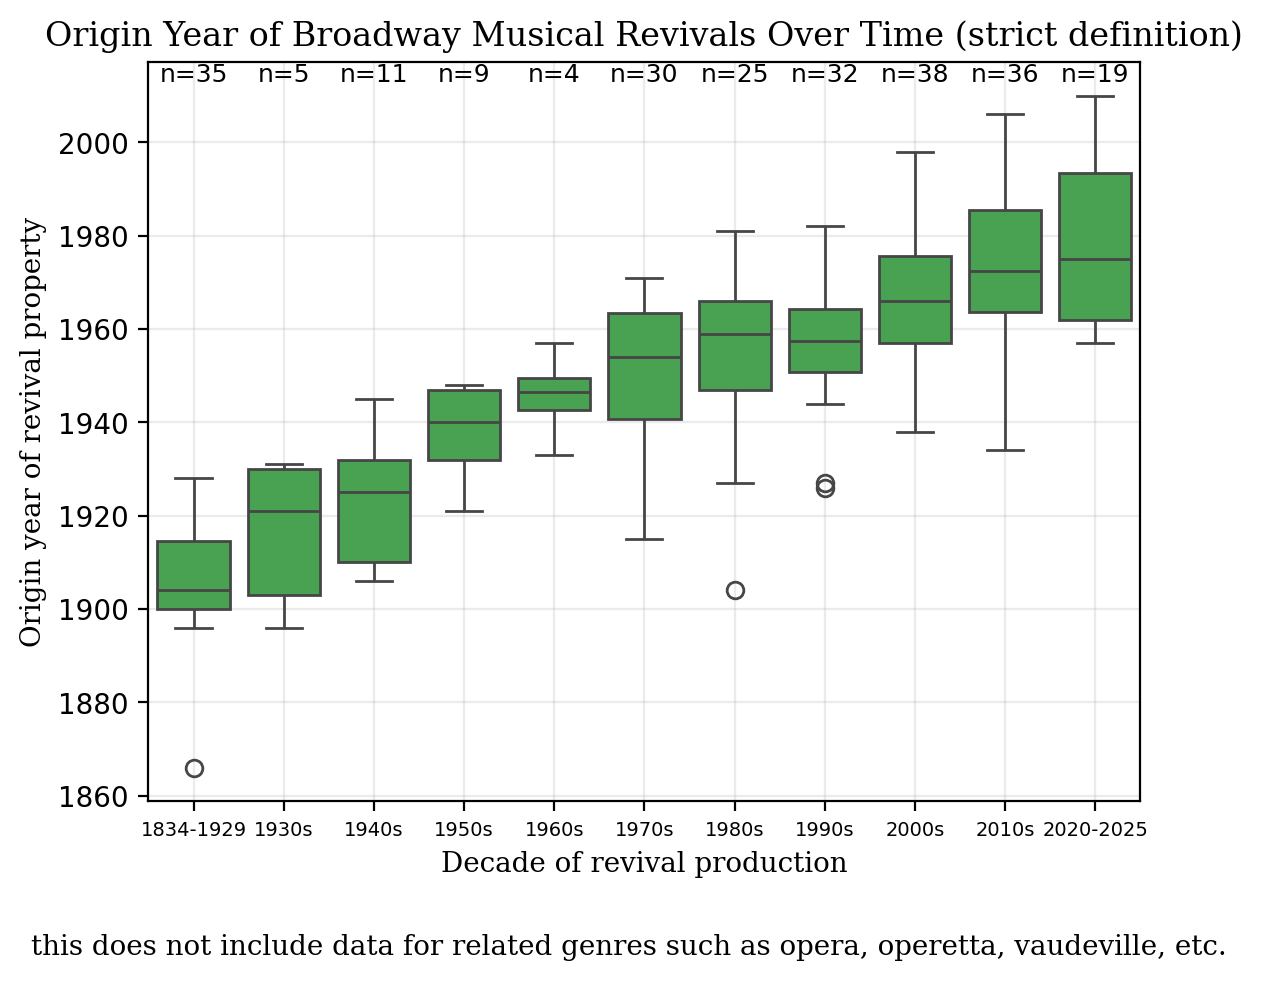

In [106]:
bins3 = [1834, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2025]
bin_labels3 = ['1834-1929', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020-2025']

# NEED TO REDEFINE ALL_REVIALS_DF for this context
# original_df = strict_musicals_df[strict_musicals_df['type_id']=='11']
# revival_df = strict_musicals_df[strict_musicals_df['type_id']=='12']
# all_revivals_df4 = pd.merge(revival_df, original_df, on='property_id',how='inner')

binned_strict_revivals_df = strict_revivals_df.copy()
binned_strict_revivals_df['og_opening_year_bin'] = pd.cut(binned_strict_revivals_df['og_opening_year'], bins=bins3, labels=bin_labels3, include_lowest=True)
binned_strict_revivals_df['og_opening_year_bin']=binned_strict_revivals_df['og_opening_year_bin'].astype(str) 
binned_strict_revivals_df['rev_opening_year_bin'] = pd.cut(binned_strict_revivals_df['rev_opening_year'], bins=bins3, labels=bin_labels3, include_lowest=True)
binned_strict_revivals_df['rev_opening_year_bin']=binned_strict_revivals_df['rev_opening_year_bin'].astype(str)

ax = sns.boxplot(x='rev_opening_year_bin', y='og_opening_year', data=binned_strict_revivals_df, order=bin_labels3, color="#3ab046")
plt.xlabel('Decade of revival production', fontfamily="serif")
plt.xticks(fontsize=7)
plt.grid(alpha=0.25)
plt.ylabel('Origin year of revival property', fontfamily="serif")
plt.figtext(0.5, -0.05, "this does not include data for related genres such as opera, operetta, vaudeville, etc.", ha='center', fontsize=10, fontfamily="serif")
plt.title("Origin Year of Broadway Musical Revivals Over Time (strict definition)", fontfamily="serif")

# this code is written by ChatGPT and puts the value counts of each bin above the box.
counts4 = binned_strict_revivals_df['rev_opening_year_bin'].value_counts()
for i, category in enumerate(bin_labels3):
    count = counts4[category] if category in counts4 else 0  # Get count or default to 0
    ax.annotate(f'n={count}', xy=(i, binned_strict_revivals_df['og_opening_year'].max()), xytext=(0,5), 
                textcoords="offset points", ha='center', fontsize=9, color="black")
plt.show()

Trying to make a bar chart of revivals versus originals that opened in each decade

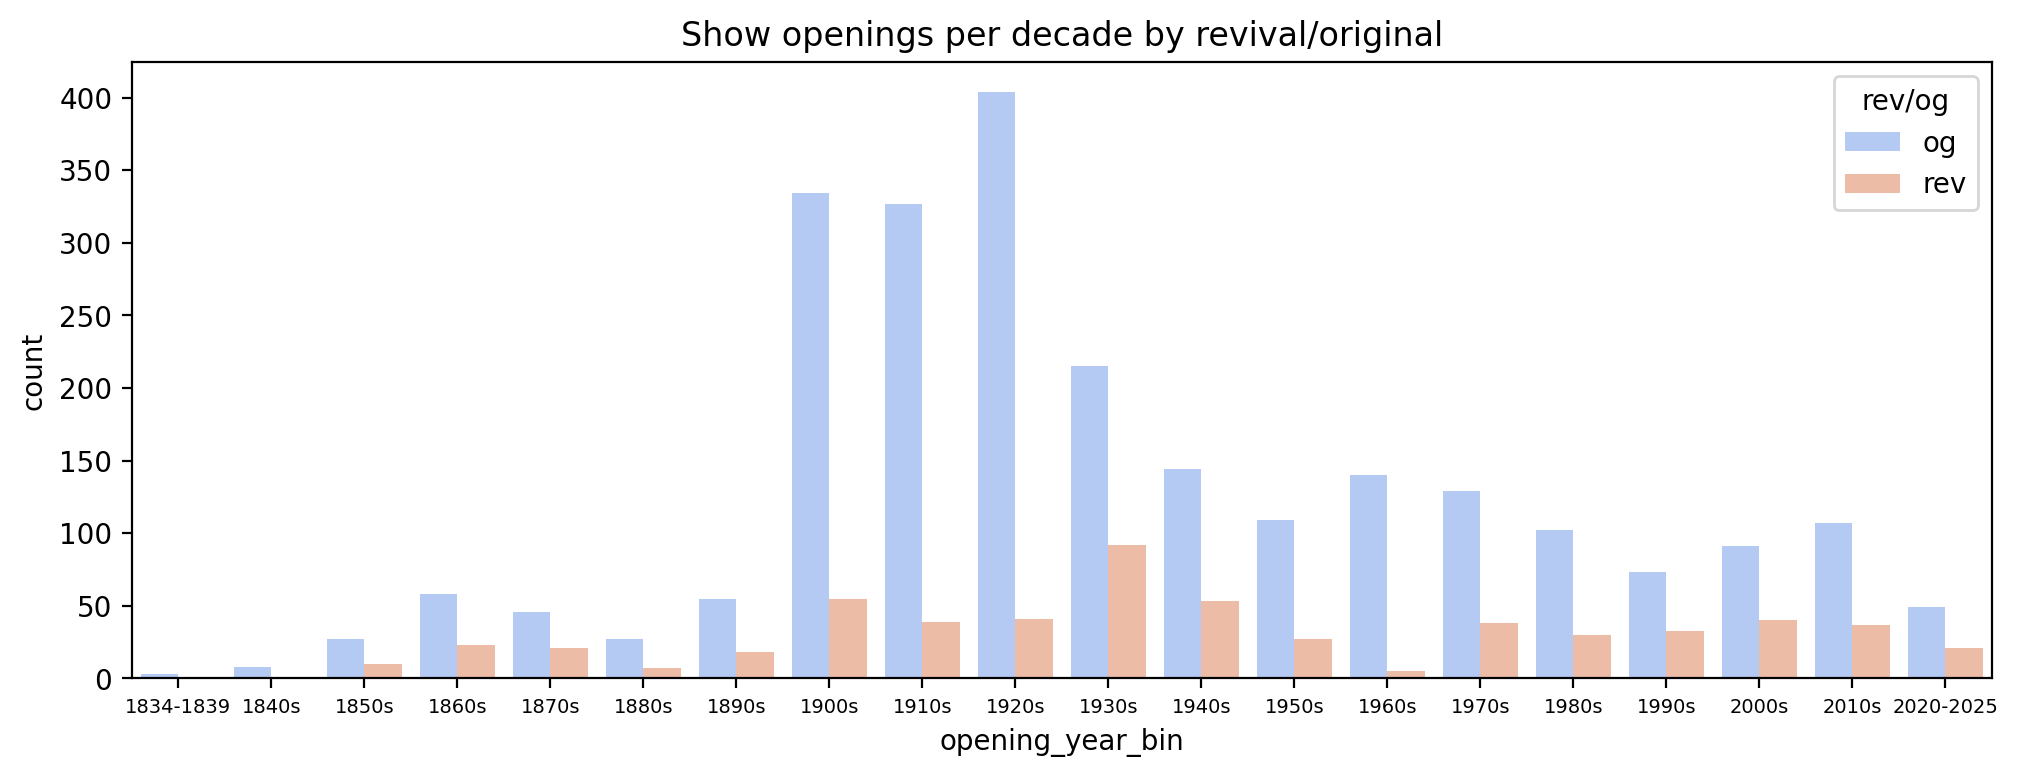

In [83]:
bins4 = [1834, 1839, 1849, 1859, 1869, 1879, 1889, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2025]
bin_labels4 = ['1834-1839', '1840s', '1850s', '1860s', '1870s', '1880s', '1890s', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020-2025']

# original_df, revival_df
original_df_binned = original_df.copy()
revival_df_binned = revival_df.copy()

original_df_binned['opening_year_bin']=pd.cut(original_df_binned['opening_year'], bins=bins4, labels=bin_labels4, include_lowest=True)
original_df_binned['opening_year_bin']=original_df_binned['opening_year_bin'].astype(str) 
revival_df_binned['opening_year_bin']=pd.cut(revival_df_binned['opening_year'], bins=bins4, labels=bin_labels4, include_lowest=True)
revival_df_binned['opening_year_bin']=revival_df_binned['opening_year_bin'].astype(str) 

og_bin_counts = pd.DataFrame(original_df_binned['opening_year_bin'].value_counts().reindex(bin_labels4, fill_value=0))
rev_bin_counts = pd.DataFrame(revival_df_binned['opening_year_bin'].value_counts().reindex(bin_labels4, fill_value=0))
# print(rev_bin_counts)
# print(og_bin_counts)

both_bin_counts = pd.merge(og_bin_counts, rev_bin_counts, on='opening_year_bin', how='inner').reset_index()
both_bin_counts.columns = ['opening_year_bin', 'og', 'rev']

#plt.plot(both_bin_counts)
both_bin_counts_melted = both_bin_counts.melt(id_vars='opening_year_bin', var_name='rev/og', value_name='count')
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=both_bin_counts_melted, x='opening_year_bin', y='count', hue='rev/og', palette='coolwarm', ax=ax, order=bin_labels4)

# sns.barplot(data=og_bin_counts, x='opening_year_bin', y='count', order=bin_labels4)
# #sns.barplot(data=rev_bin_counts, x='opening_year_bin', y='count', order=bin_labels4)
# sns.barplot(data=rev_bin_counts, x='opening_year_bin', y='count')
plt.title('Show openings per decade by revival/original')
plt.xticks(fontsize=7)
plt.show()

# TO DO: rename the columns before melting or merging. then make the grouped barchart according to chatgpt in seaborn using this melted data.


Let's try representing this same data as a stacked bar chart, so we can also see how the TOTAL changes over time

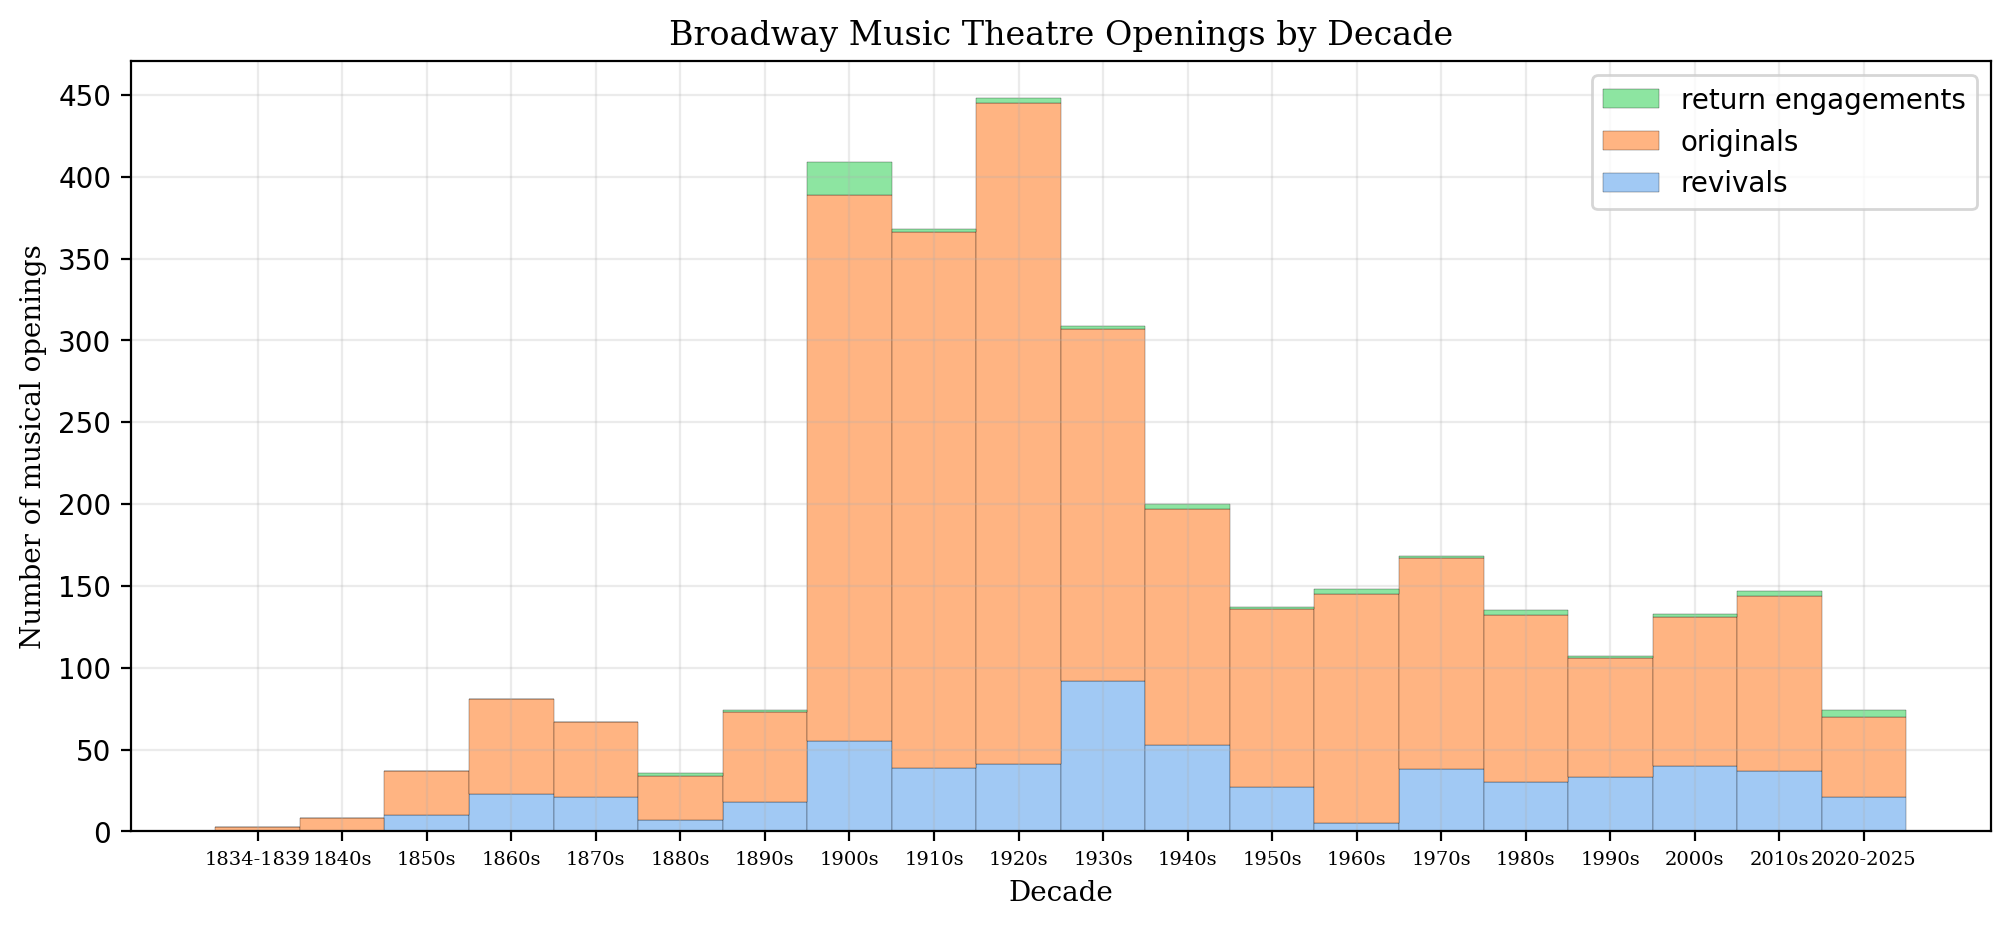

In [112]:
ticks = np.arange(len(both_bin_counts))
colors = sns.color_palette("pastel", 3)

# prepare return engagement information
rtn_engagement_binned=rtn_engagement_df.copy()
rtn_engagement_binned['opening_year_bin']=pd.cut(rtn_engagement_binned['opening_year'], bins=bins4, labels=bin_labels4, include_lowest=True)
rtn_engagement_counts = pd.DataFrame(rtn_engagement_binned['opening_year_bin'].value_counts().reindex(bin_labels4, fill_value=0)).reset_index()

# make a stacked bar chart!
fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(ticks, both_bin_counts['rev'], label='rev', color=colors[0], width=1.0, edgecolor='black', linewidth=0.1)
bars2 = ax.bar(ticks, both_bin_counts['og'], bottom=both_bin_counts['rev'], label='og', color=colors[1], width=1.0, edgecolor='black', linewidth=0.1)
bars3 = ax.bar(ticks, rtn_engagement_counts['count'], bottom=np.array(both_bin_counts['rev']) + np.array(both_bin_counts['og']), label='og', color=colors[2], width=1.0, edgecolor='black', linewidth=0.1)
ax.set_xticks(ticks)
ax.set_xticklabels(both_bin_counts['opening_year_bin'], fontfamily="serif")
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

# reset the order of the legend 
handles, labels = ax.get_legend_handles_labels()
labels = ['revivals', 'originals', 'return engagements']
ax.legend(handles[::-1], labels[::-1])

plt.xticks(fontsize=7)
plt.grid(alpha=0.25) # add a grid
plt.title('Broadway Music Theatre Openings by Decade', fontfamily="serif") # add a title
plt.xlabel('Decade', fontfamily="serif")
plt.ylabel('Number of musical openings', fontfamily="serif")
plt.show()

In [85]:
for key, value in binned_strict_revivals_df.iterrows():
    if value['rev_opening_year_bin']=='2010s':
        print(value['rev_title'])

Annie
Anything Goes
Cabaret
Carousel
Cats
Evita
Falsettos
Fiddler on the Roof
Follies
Gigi
Godspell
Hair
Hello, Dolly!
How to Succeed in Business Without Really Trying
Jekyll & Hyde
Jesus Christ Superstar
Kiss Me, Kate
La Cage aux Folles
Les Misérables
Miss Saigon
My Fair Lady
Oklahoma!
On a Clear Day You Can See Forever
On the Town
On the Twentieth Century
Once on This Island
Pippin
Promises, Promises
She Loves Me
Side Show
Spring Awakening
Sunday in the Park with George
Sunset Boulevard
The Color Purple
The King and I
The Mystery of Edwin Drood


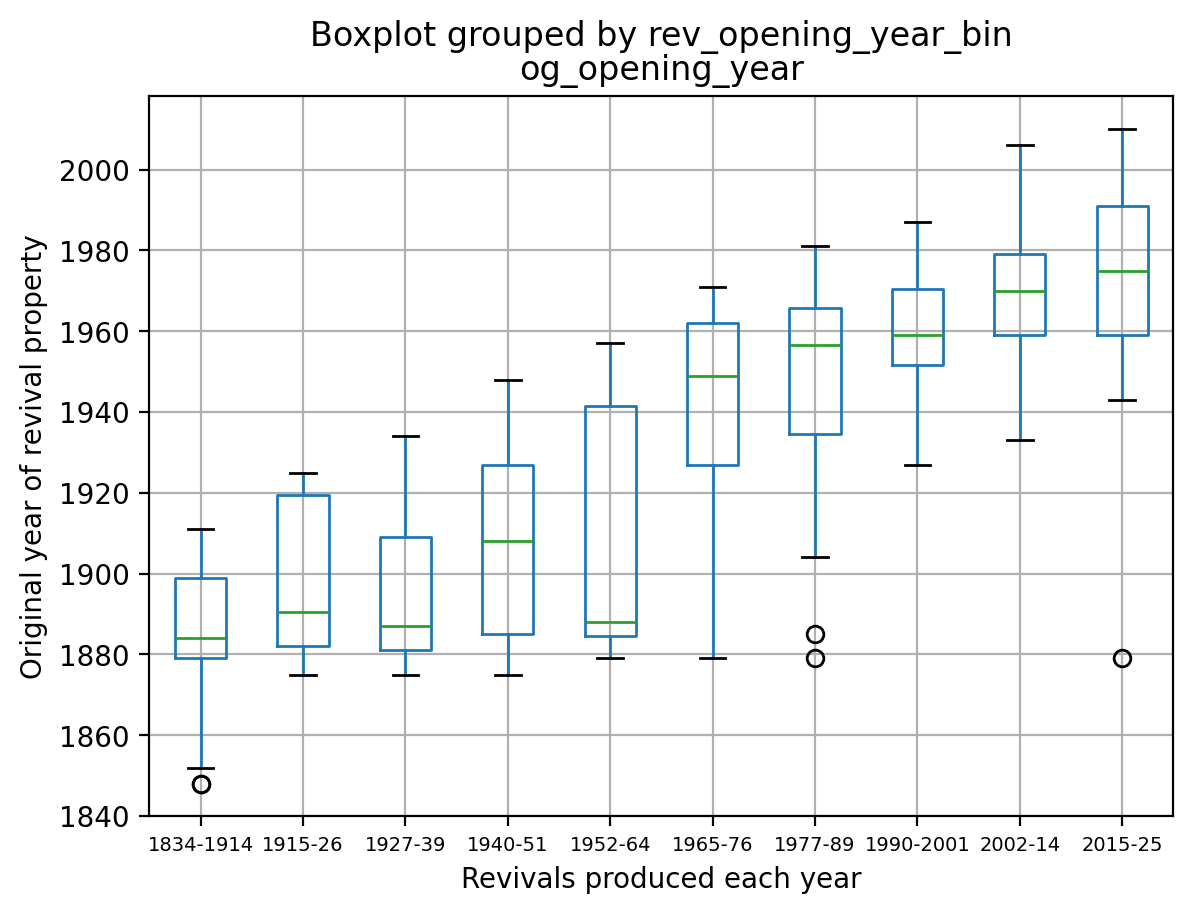

In [86]:
bins2 = [1834, 1915, 1927, 1940, 1952, 1965, 1977, 1990, 2002, 2015, 2025]
bin_labels2 = ['1834-1914', '1915-26', '1927-39', '1940-51', '1952-64', '1965-76', '1977-89', '1990-2001', '2002-14', '2015-25']

binned_all_revivals_df2 = all_revivals_df.copy()
binned_all_revivals_df2['og_opening_year_bin'] = pd.cut(binned_all_revivals_df2['og_opening_year'], bins=bins2, labels=bin_labels2, include_lowest=True)
binned_all_revivals_df2['og_opening_year_bin']=binned_all_revivals_df2['og_opening_year_bin'].astype(str) 
binned_all_revivals_df2['rev_opening_year_bin'] = pd.cut(binned_all_revivals_df2['rev_opening_year'], bins=bins2, labels=bin_labels2, include_lowest=True)
binned_all_revivals_df2['rev_opening_year_bin']=binned_all_revivals_df2['rev_opening_year_bin'].astype(str)
binned_all_revivals_df2.boxplot(column='og_opening_year', by='rev_opening_year_bin')
plt.xlabel('Revivals produced each year')
plt.xticks(fontsize=7)
plt.ylabel('Original year of revival property')
plt.show()

I want to just look at 1920s onward

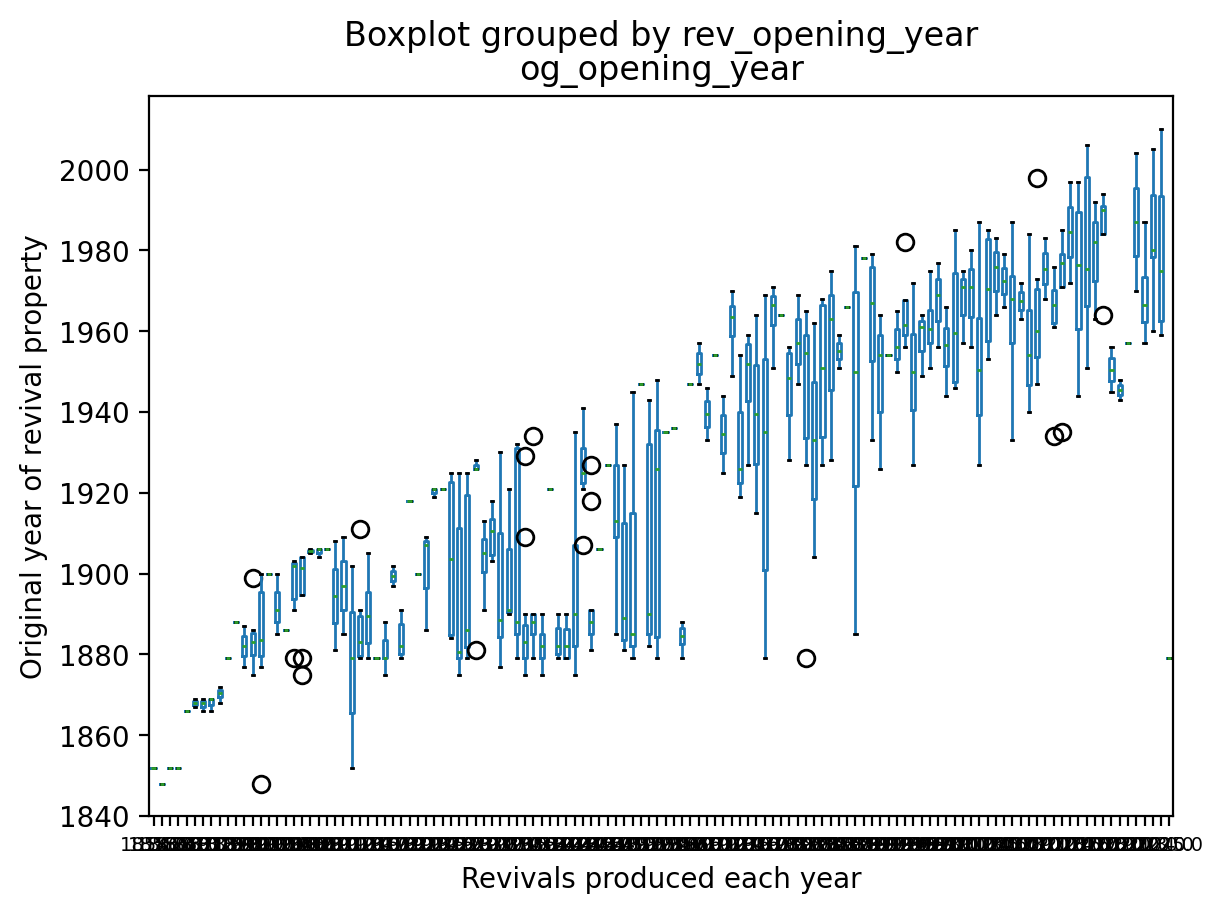

In [87]:
all_revivals_df.boxplot(column='og_opening_year', by='rev_opening_year', grid=False)
plt.xlabel('Revivals produced each year')
plt.xticks(fontsize=7)
plt.ylabel('Original year of revival property')
plt.subplots(figsize=(120, 50))
plt.show()

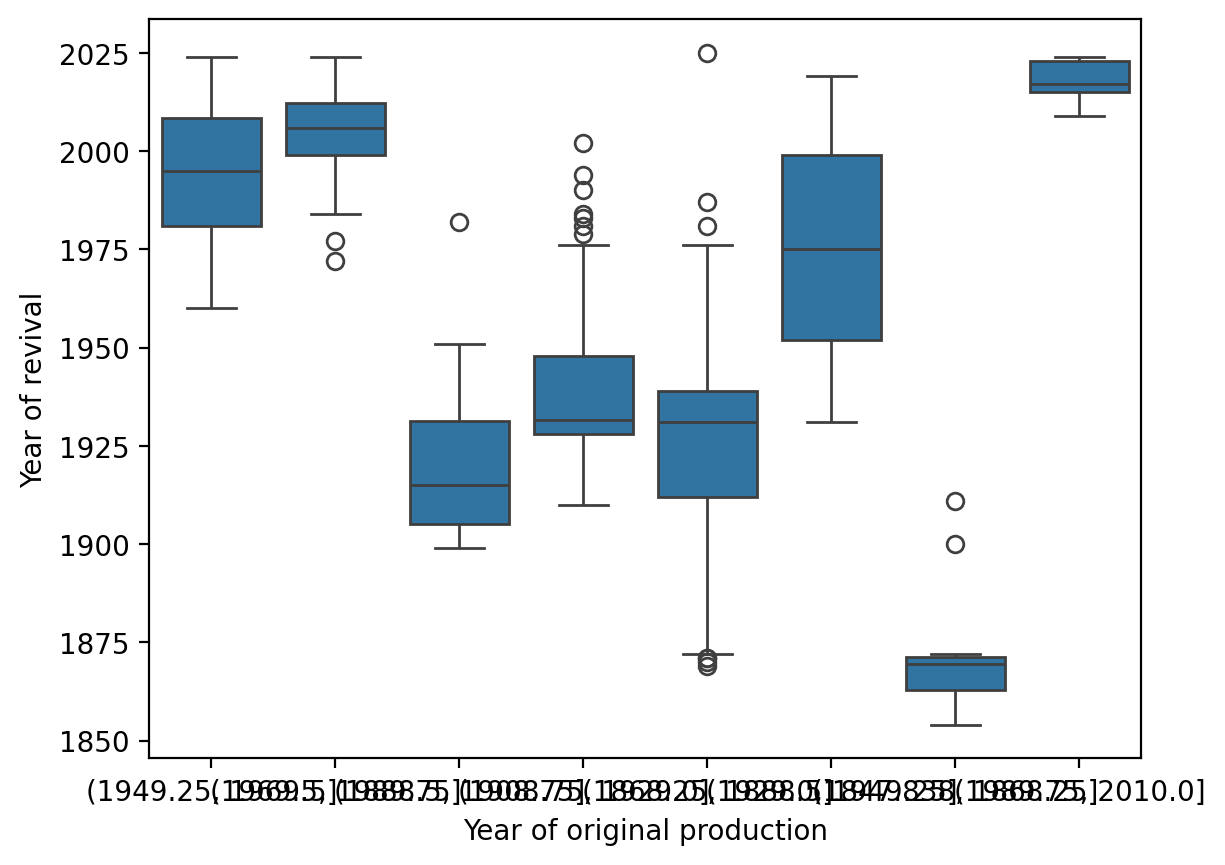

In [88]:
import seaborn as sns
sns.boxplot(x='og_opening_year_bin', y='rev_opening_year', data=binned_all_revivals_df)
plt.xlabel('Year of original production')
plt.ylabel('Year of revival')
plt.show()

Let's look now at some analyses of movie musicals.

In [89]:
screen_query1 = "SELECT * FROM screen_work"
screen_df = pd.read_sql_query(screen_query1, con=connection)
screen_df['release_date'] = pd.to_datetime(screen_df['release_date'])
screen_df['release_year'] = screen_df['release_date'].apply(take_year)

C:\Users\12676\AppData\Local\Temp\ipykernel_22040\2108290734.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  screen_df = pd.read_sql_query(screen_query1, con=connection)


Let's plot merge the screen works with the stage originals and revivals

In [90]:
screen_df
all_works_df = pd.merge(screen_df, stage_df, on='property_id',how='inner')

all_works_df.columns = ['screen_work_id', 'screen_property_id', 'screen_type_id', 'screen_title', 'screen_release_date',
       'tmdb_url', 'us_origin', 'tmdb_popularity', 'screen_budget', 'screen_revenue',
       'tmdb_rating', 'tmdb_vote_count', 'assoc_stage_work_id', 'screen_release_year',
       'stage_work_id', 'stage_type_id', 'stage_title', 'ibdb_url', 'stage_opening_date',
       'stage_preview_start_date', 'stage_closing_date', 'stage_opening_year']


Looking at all of these together is not very informative. Especially because the way it merges them isn't very informative? What it does is it pairs every permutation of stage and screen musical of the same property id. Which is too broad.

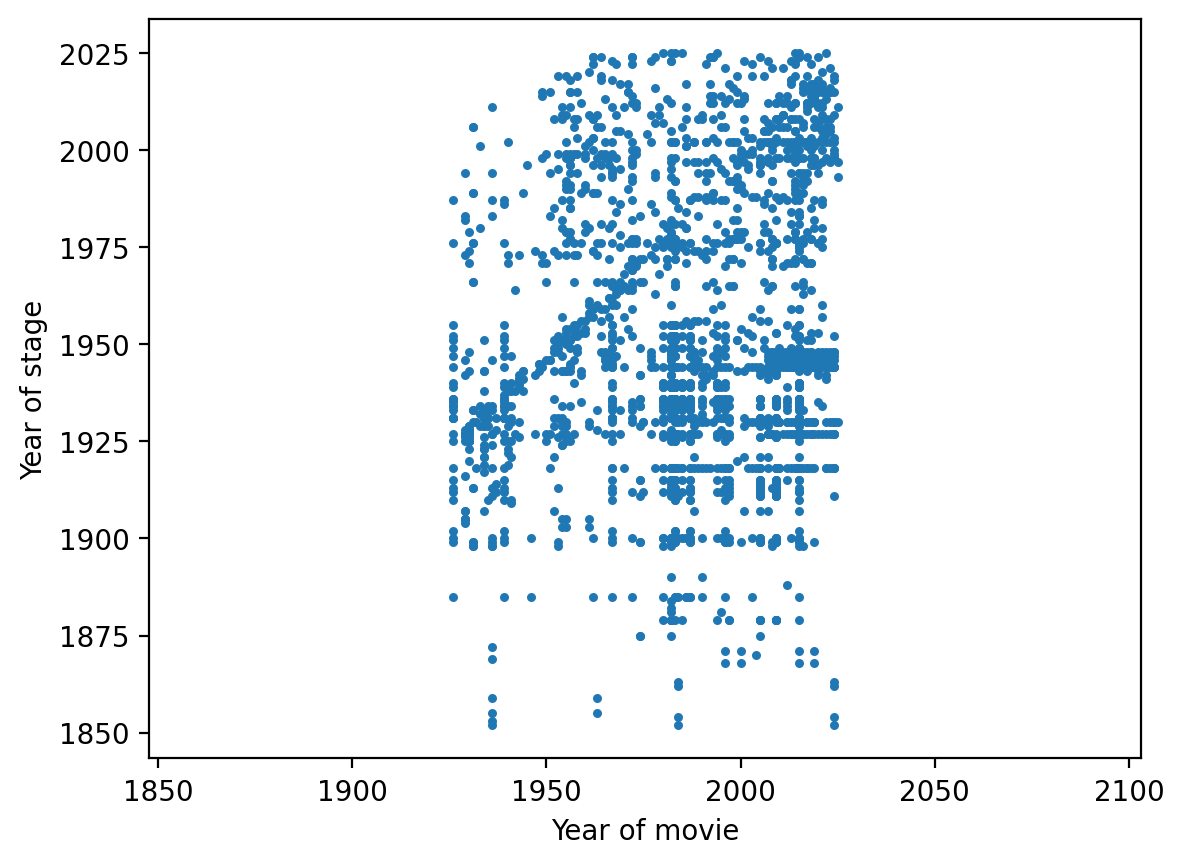

In [91]:
plt.scatter(all_works_df['screen_release_year'], all_works_df['stage_opening_year'], s=5)
plt.axis('equal')
plt.xlabel('Year of movie')
plt.ylabel('Year of stage')
plt.show()

Let's instead look at only MOVIES and original stage productions. We already have a df of originals above

In [92]:
movie_df = screen_df.loc[screen_df['type_id']=='21']
#movie_df

og_movie_df = pd.merge(movie_df, original_df, on='property_id', how='inner')
og_movie_df.columns = ['screen_work_id', 'screen_property_id', 'screen_type_id', 'screen_title', 'screen_release_date',
       'tmdb_url', 'us_origin', 'tmdb_popularity', 'screen_budget', 'screen_revenue',
       'tmdb_rating', 'tmdb_vote_count', 'assoc_stage_work_id', 'screen_release_year',
       'stage_work_id', 'stage_type_id', 'stage_title', 'ibdb_url', 'stage_opening_date',
       'stage_preview_start_date', 'stage_closing_date', 'stage_opening_year']

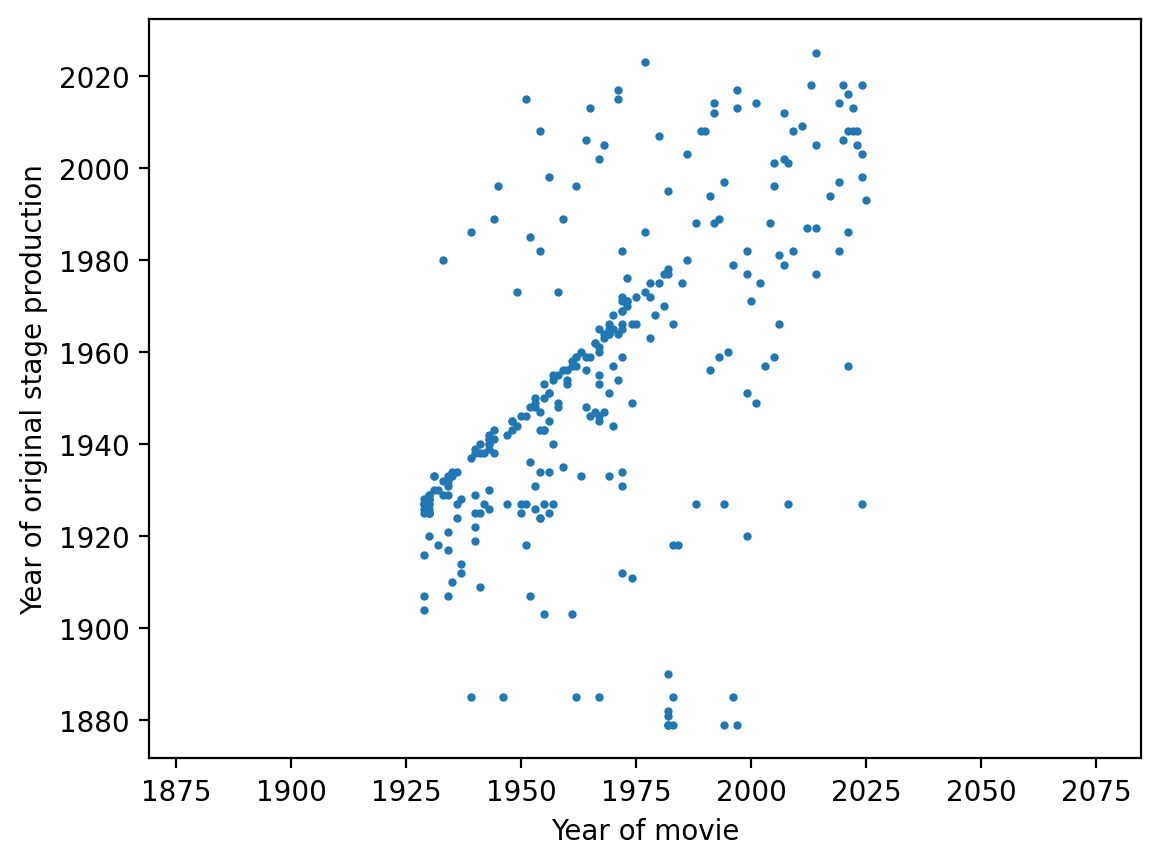

In [93]:
plt.scatter(og_movie_df['screen_release_year'], og_movie_df['stage_opening_year'], s=4)
plt.axis('equal')
plt.xlabel('Year of movie')
plt.ylabel('Year of original stage production')
plt.show()

In [94]:
first_movie_df = movie_df.loc[movie_df.groupby('property_id')['release_year'].idxmin()]
# now merge the first movies with the original stage productions
single_movie_og_df = pd.merge(original_df, first_movie_df, on='property_id',how='inner')
single_movie_og_df.columns = ['stage_work_id', 'property_id', 'stage_type_id', 'stage_title', 'ibdb_url',
       'stage_opening_date', 'stage_preview_start_date', 'stage_closing_date', 'stage_opening_year',
       'screen_work_id', 'screen_type_id', 'screen_title', 'screen_release_date', 'tmdb_url',
       'us_origin', 'tmdb_popularity', 'budget', 'revenue', 'tmdb_rating',
       'tmdb_vote_count', 'assoc_stage_work_id', 'screen_release_year']
# productions that went from movie musical --> stage musical
movie_first_df = single_movie_og_df[single_movie_og_df['screen_release_year']<single_movie_og_df['stage_opening_year']]
# productions that went from stage musical --> movie musical
stage_first_df = single_movie_og_df[single_movie_og_df['screen_release_year']>=single_movie_og_df['stage_opening_year']]


Look at trends of turning musicals into movies

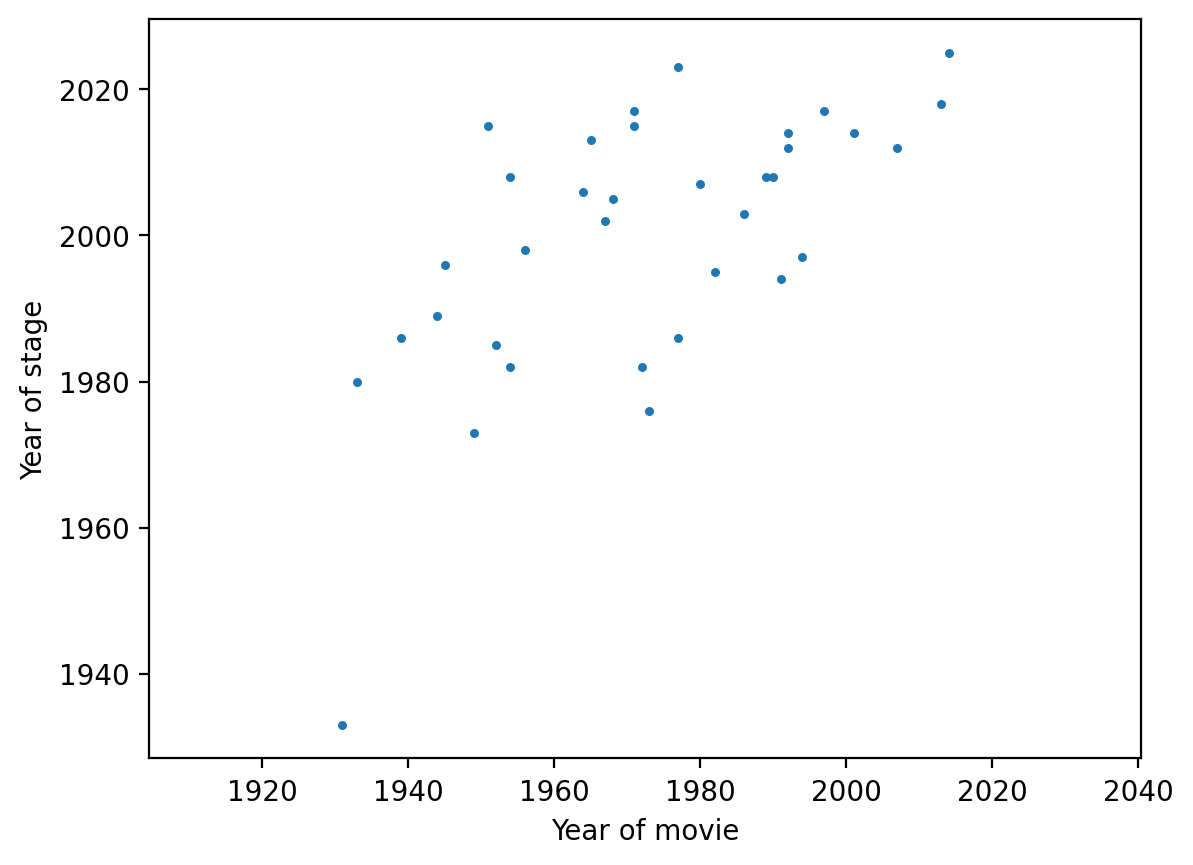

In [95]:
plt.scatter(movie_first_df['screen_release_year'], movie_first_df['stage_opening_year'], s=5)
plt.axis('equal')
plt.xlabel('Year of movie')
plt.ylabel('Year of stage')
plt.show()

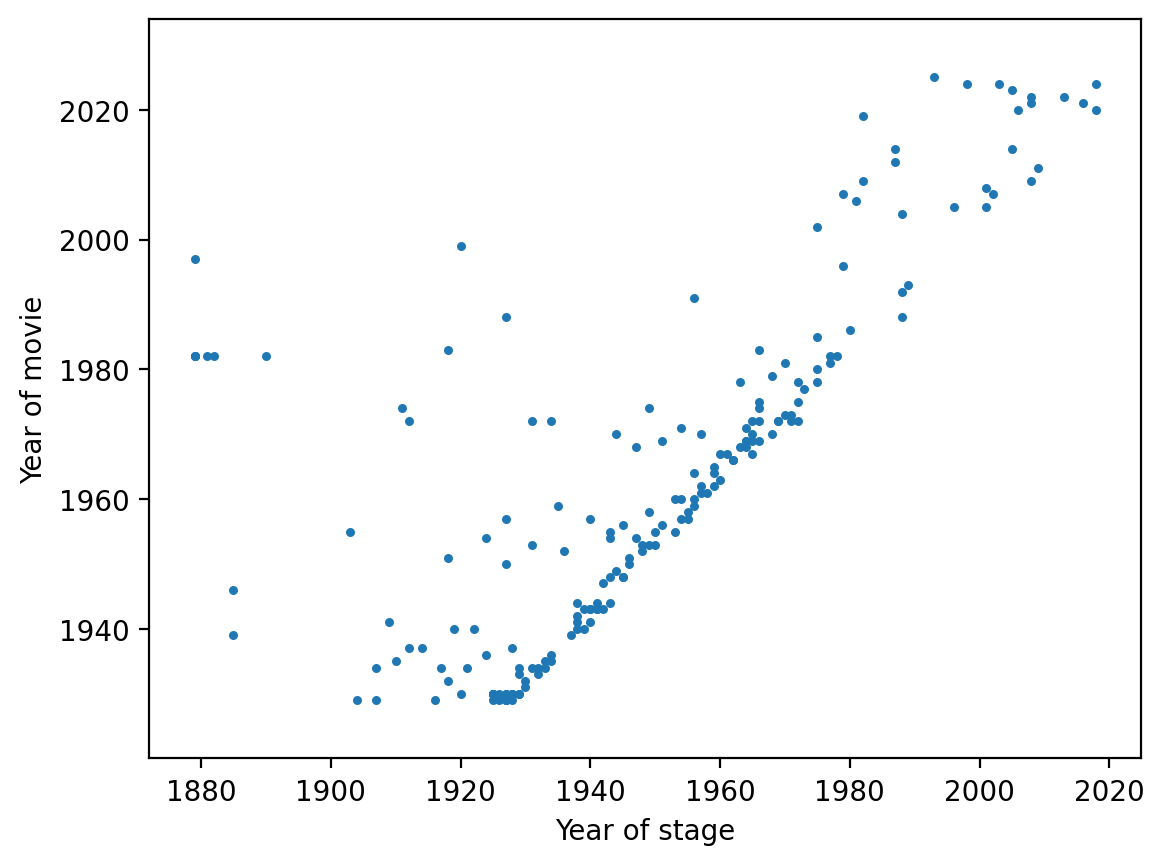

In [96]:
plt.scatter(stage_first_df['stage_opening_year'], stage_first_df['screen_release_year'], s=5)
plt.axis('equal')
plt.xlabel('Year of stage')
plt.ylabel('Year of movie')
plt.show()

Now let's look at the counts of each method per year. (Guiding question: can we see this golden age of movie musicals, as well as when the trend died off?)

In [97]:
movie_first_stage_counts = movie_first_df['stage_opening_year'].value_counts().sort_index()
movie_first_movie_counts = movie_first_df['screen_release_year'].value_counts().sort_index()
stage_first_movie_counts = stage_first_df['screen_release_year'].value_counts().sort_index()
stage_first_stage_counts = stage_first_df['stage_opening_year'].value_counts().sort_index()
movie_first_movie_counts

screen_release_year
1931    1
1933    1
1939    1
1944    1
1945    1
1949    1
1951    1
1952    1
1954    2
1956    1
1964    1
1965    1
1967    1
1968    1
1971    2
1972    1
1973    1
1977    2
1980    1
1982    1
1986    1
1989    1
1990    1
1991    1
1992    2
1994    1
1997    1
2001    1
2007    1
2013    1
2014    1
Name: count, dtype: int64

What I want to do is make a histogram with bins for a set of years. (think about when the 'golden age' of movies is considered to be)

Text(0, 0.5, 'movie release year')

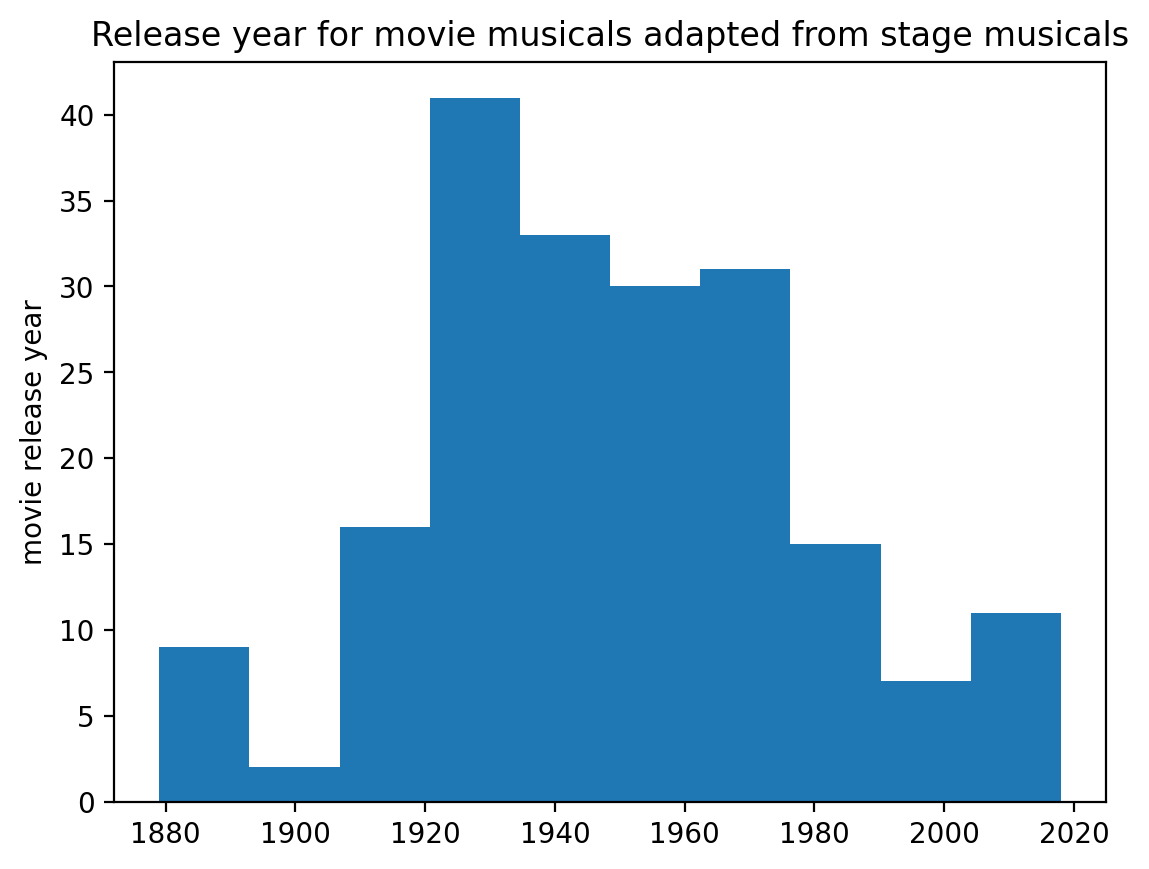

In [98]:
# turns out i didn't have to do that stuff above. 
plt.hist(stage_first_df['stage_opening_year'])
plt.title("Release year for movie musicals adapted from stage musicals")
plt.ylabel("movie release year")

In [99]:
screen_df.loc[screen_df['release_year']<1930]

,work_id,property_id,type_id,title,release_date,tmdb_url,us_origin,tmdb_popularity,budget,revenue,tmdb_rating,tmdb_vote_count,assoc_stage_work_id,release_year
205,08000121,0800,21,Hit the Deck,1929-12-25,themoviedb.org/movie/381368,1,0.140538,0.0,0.0,9.0,1,,1929
294,10720021,1072,21,Little Johnny Jones,1929-11-17,themoviedb.org/movie/328800,1,0.347500,0.0,0.0,0.0,0,,1929
358,14060021,1406,21,Paris,1929-11-07,themoviedb.org/movie/520850,1,0.118188,0.0,0.0,0.0,0,,1929
388,15250021,1525,21,Rio Rita,1929-09-15,themoviedb.org/movie/53760,1,0.877250,678000.0,2400000.0,8.5,2,,1929
408,16070521,1607,21,Show Boat,1929-07-27,themoviedb.org/movie/237067,1,0.208085,0.0,0.0,5.0,2,,1929
415,16460021,1646,21,So Long Letty,1929-10-16,themoviedb.org/movie/130813,1,0.200281,0.0,0.0,5.9,7,,1929
490,18560021,1856,21,The Cocoanuts,1929-05-23,themoviedb.org/movie/20625,1,0.381974,500000.0,1800000.0,6.4,113,,1929
496,18790121,1879,21,The Desert Song,1929-04-08,themoviedb.org/movie/262260,1,0.183640,354000.0,3022000.0,4.5,2,,1929
547,21120723,2112,23,The Mikado,1926-05-02,themoviedb.org/movie/338621,0,0.100000,0.0,0.0,0.0,0,,1926
573,23040021,2304,21,"The Time, the Place and the Girl",1929-07-07,themoviedb.org/movie/472877,1,0.094452,0.0,0.0,0.0,0,,1929
